In [3]:
# Useful commamnds
!rm -rf /kaggle/working/*

In [4]:
!pwd
!ls -a

/kaggle/working
.  ..  .virtual_documents


Reference Github: https://github.com/BreezeWhite/oemer

In [5]:
import numpy as np
from PIL import Image
import xml.etree.ElementTree as ET
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

doremi_dir = "/kaggle/input/doremi-raw-dataset/DoReMi_v1/"
IMAGE_WIDTH = 2475
IMAGE_HEIGHT = 1577

# Sample data

Importing sample image from the [DoReMi](https://github.com/steinbergmedia/DoReMi/?tab=readme-ov-file#OMR-metadata) dataset.

In [6]:
img_path = doremi_dir + 'Images/Alkan - Posement-001.png'
image = Image.open(img_path)

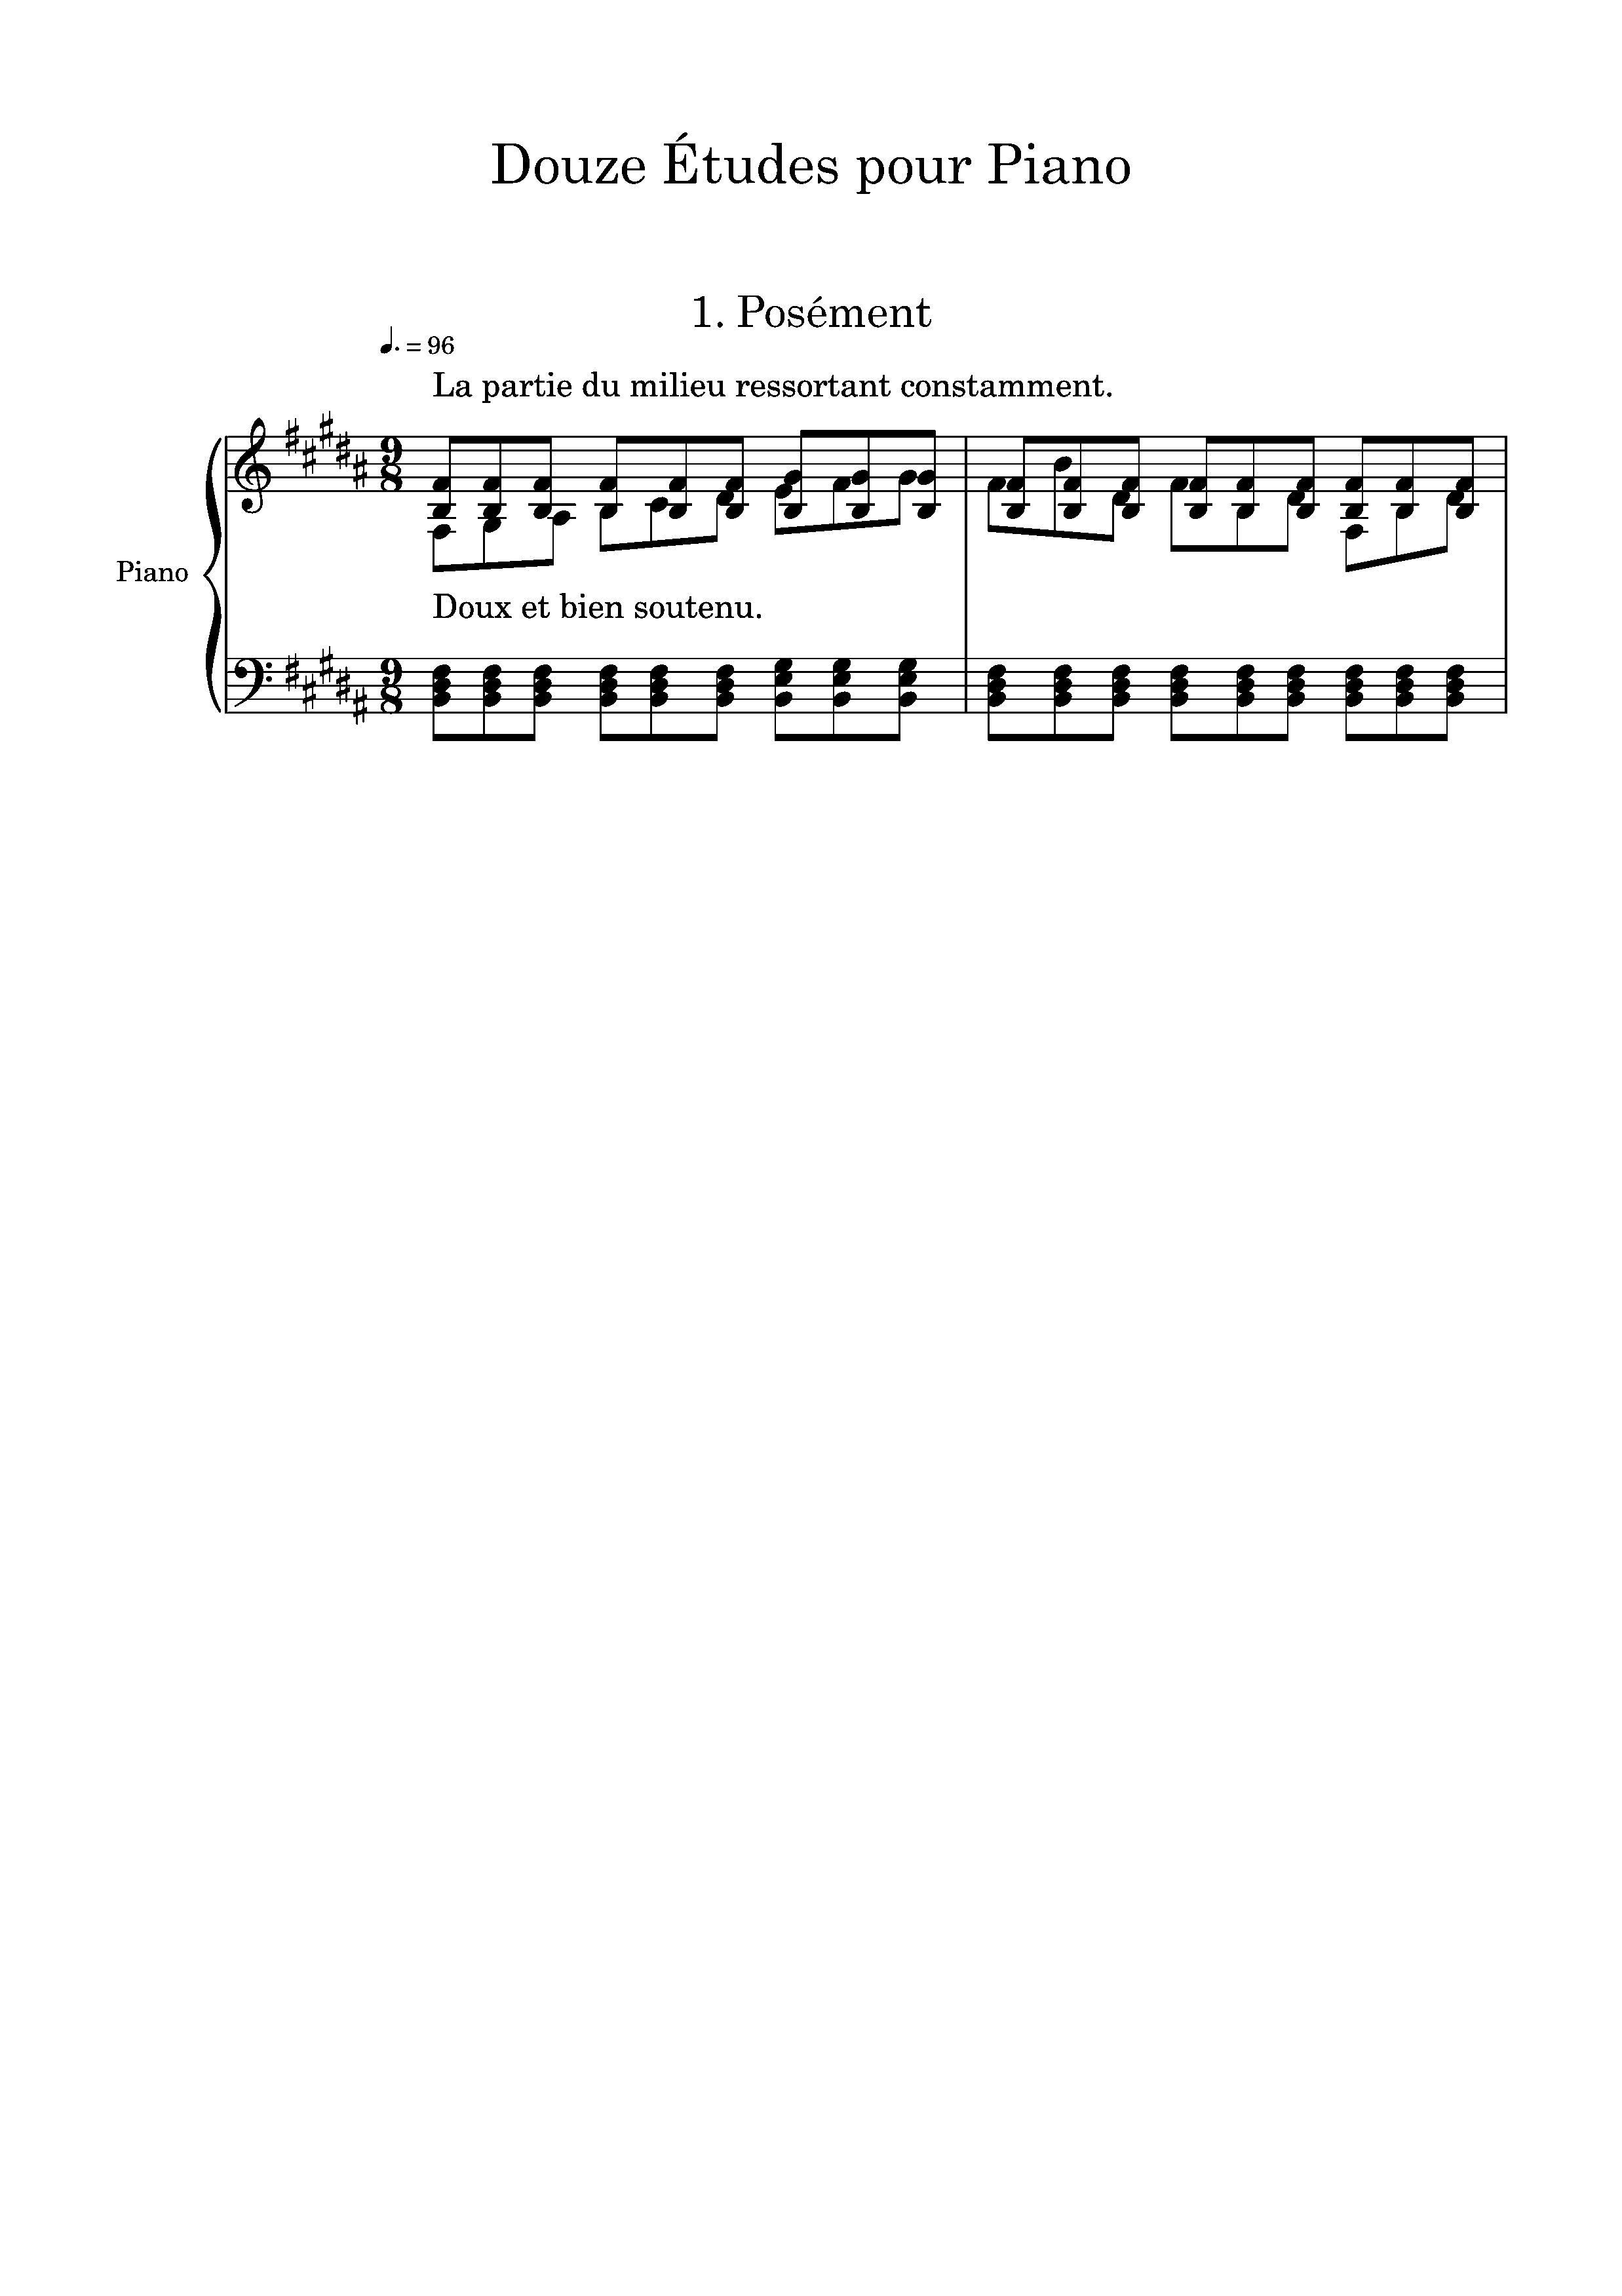

In [7]:
image

In [8]:
file_path = doremi_dir + 'OMR_XML/Alkan - Posement-layout-0-muscima.xml'
with open(file_path, 'r') as file:
    content = file.read(200)
    print(content)

<?xml version="1.0" encoding="utf-8"?>
<Pages><Page pageIndex="0"><Nodes><Node><Id>230</Id><ClassName>accidentalSharp</ClassName><Top>1049</Top><Left>539</Left><Width>21</Width><Height>59</Height><Mas


# Preprocessing Data

## Cropping Input Image
To adjust the size of our data, we wrote a python script to crop the input image. 

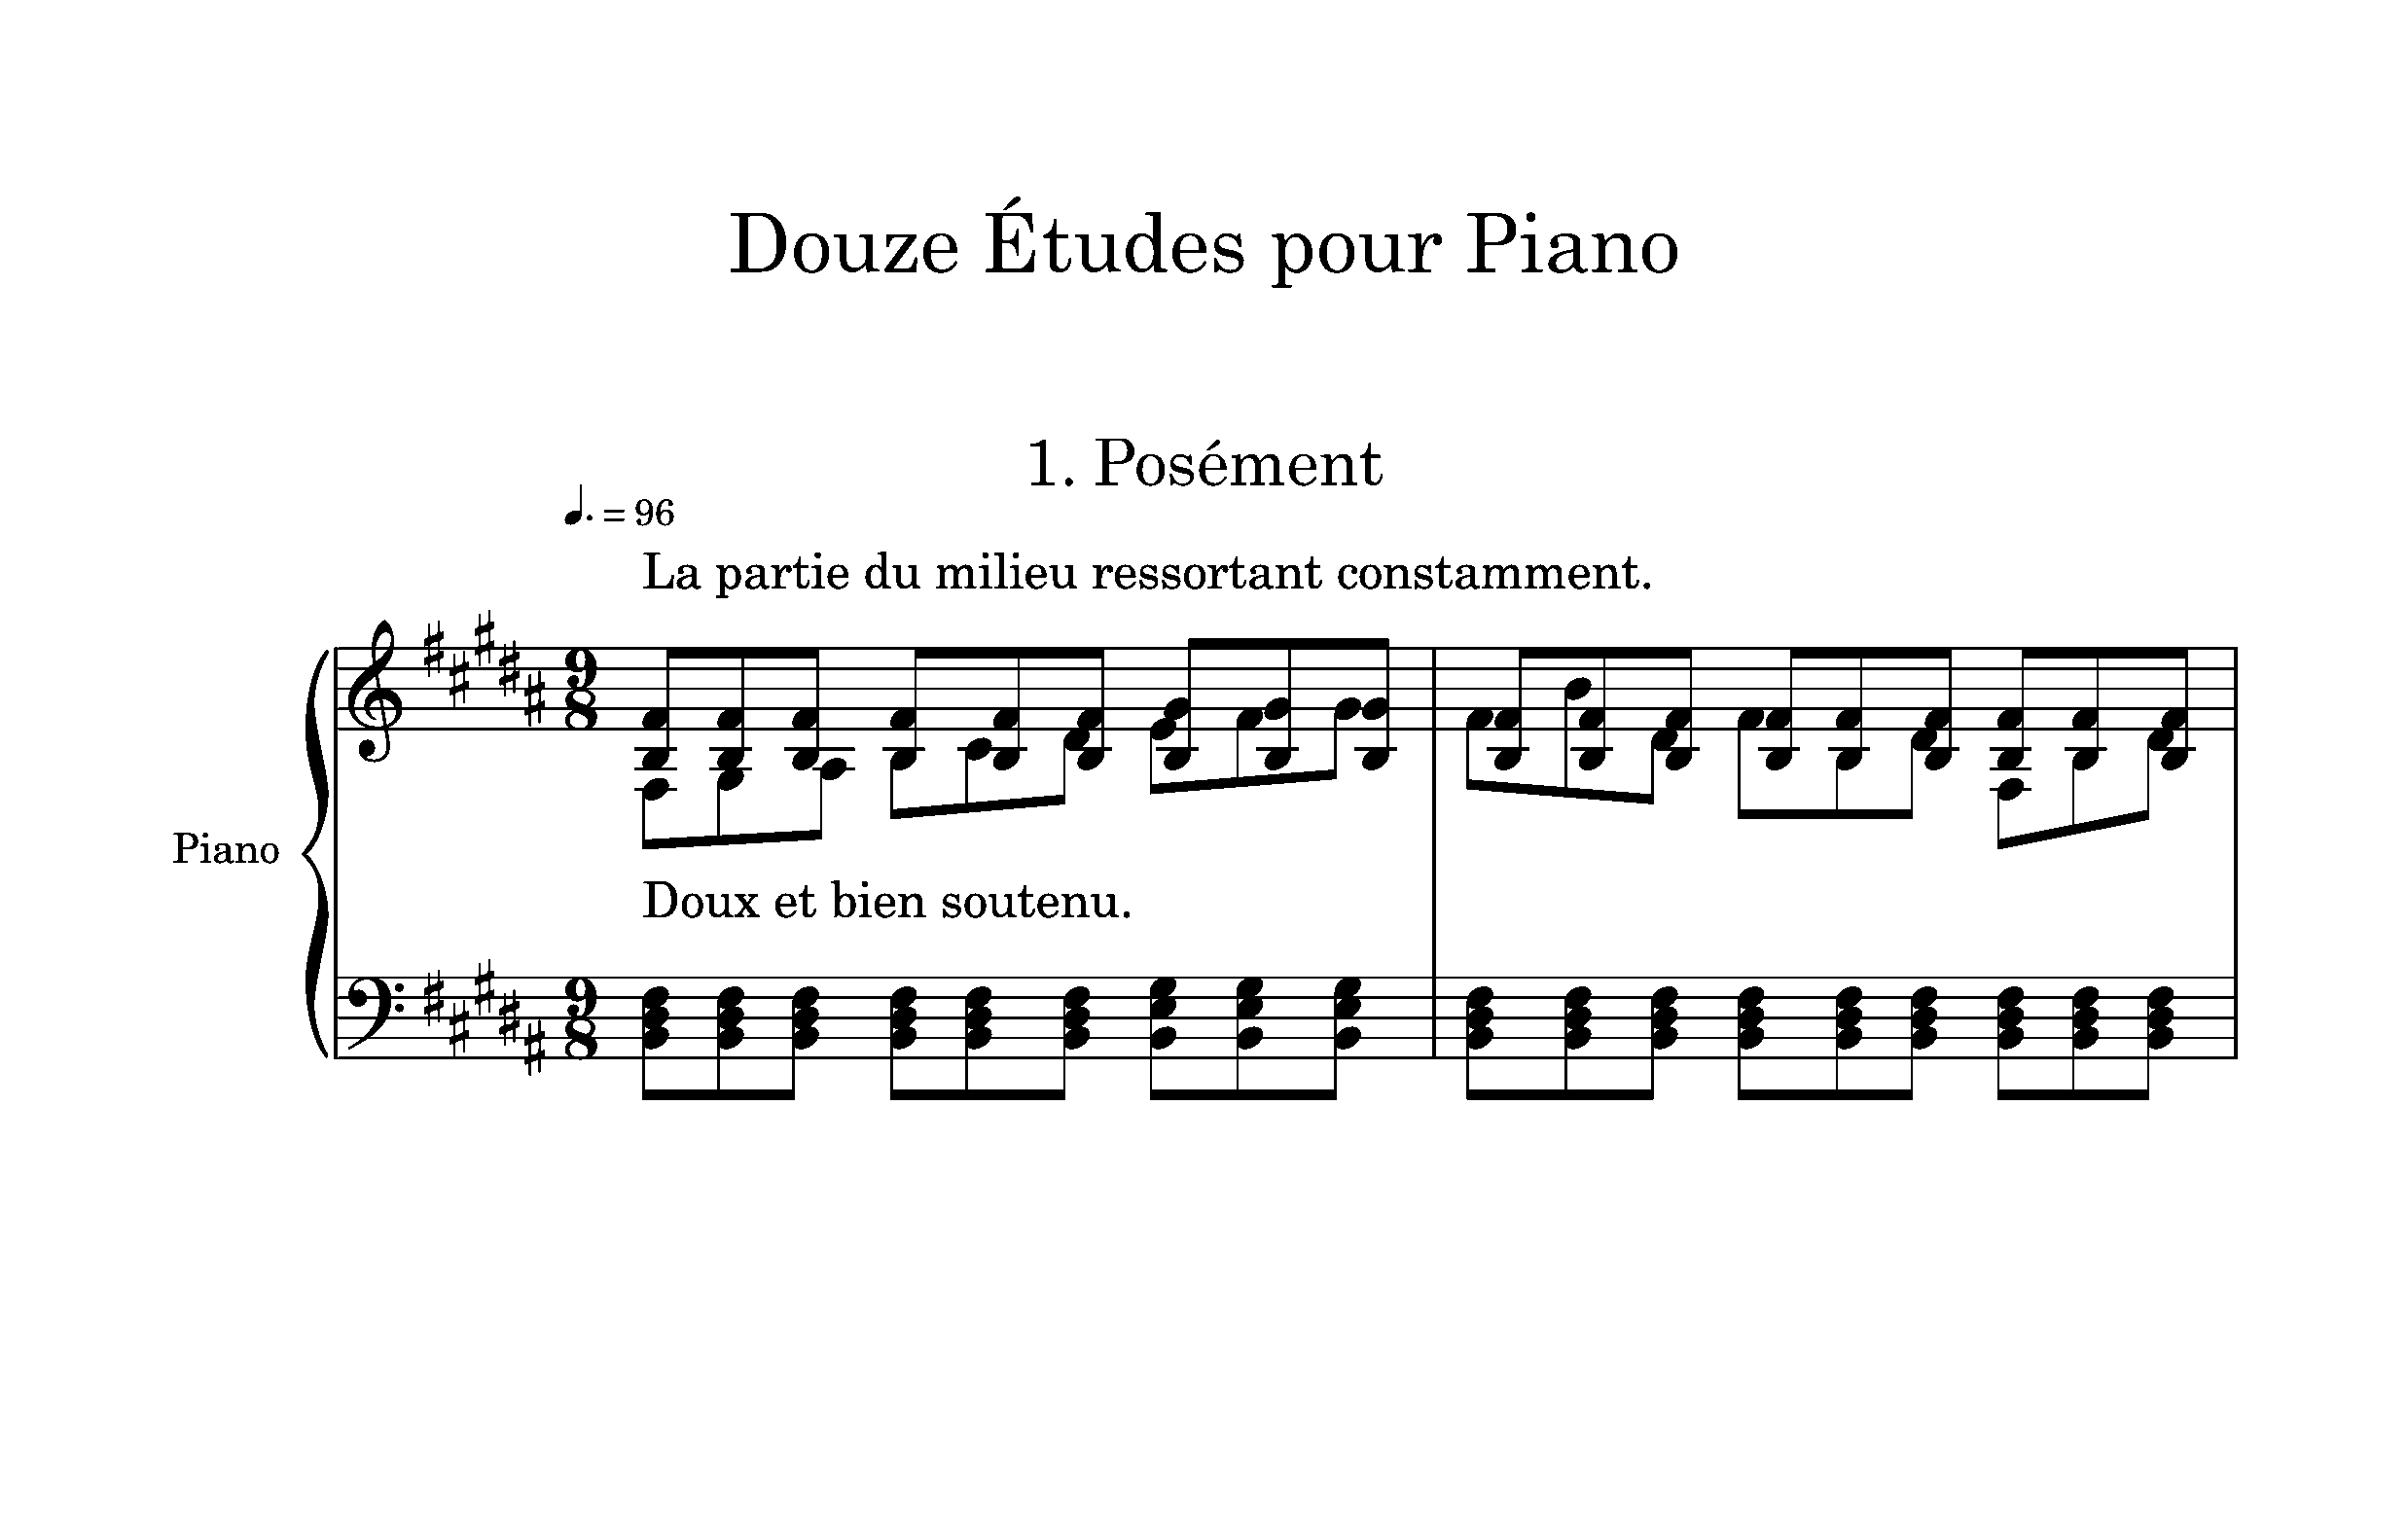

In [9]:
from IPython.display import display

def crop_top_half(image_path):
    """
    Crops the top half of the image.

    Parameters:
    - image_path: str, path to the input image.

    Returns:
    - cropped_image: PIL.Image.Image, the cropped top half of the image.
    """
    image = Image.open(image_path)

    width, height = image.size
    crop_height = height * 0.45
    crop_box = (0, 0, width, crop_height)
    cropped_image = image.crop(crop_box)
    
    return cropped_image

# Example usage
input_image_path = doremi_dir + 'Images/Alkan - Posement-001.png'
cropped_image = crop_top_half(input_image_path)

display(cropped_image)

## Staffline Extraction
First, we will extract stafflines. This step is the most important as the music scores are determined by their relative position to the stafflines. We will extract the following information for each staffline, which are fundamental for the later parts of this project. 

In [10]:
# example output of staff extraction
# Staff {
#     Center: 0.0 # y-center 
#     Upper bound: 150 # upper bound of the block
#     Lower bound: 200 # lower bound of the block
#     Unit size: 5.0 # distance between each stafflines
#     Track: 1 # for a two-handed piano score, track 1 would be for the left hand and track 2 would be for right hand
#     Group: 3 # for a two-handed piano score, two tracks are grouped into one
# }

In [11]:
class Line:
    def __init__(self) -> None:
        self.points = [] # stores the (x,y) pixels that make up the line
        self.label = "" # FIRST, SECOND, THIRD, FOURTH, FIFTH

    def add_point(self, x:int, y:int) -> None:
        self.points.append((x,y))
        self.y_center = None
        self.upper = None
        self.lower = None
        self.x_center = None
        self.x_left = None
        self.x_right = None 
        

In [12]:
class Staff:
    def __init(self) -> None:
        self.lines = List[Line]
        self.track = None
        self.group = None

# Boundary Thought Process: 

In [13]:
class Staff:
    def __init__(self, center: float, upper_bound: int, lower_bound: int, unit_size: float, track: int):
        self.center = center
        self.upper_bound = upper_bound
        self.lower_bound = lower_bound
        self.unit_size = unit_size
        self.track = track

    def __repr__(self):
        return (
            "Staff {\n"
            f"    Center: {self.center:.1f}\n"
            f"    Upper bound: {self.upper_bound}\n"
            f"    Lower bound: {self.lower_bound}\n"
            f"    Unit size: {self.unit_size:.1f}\n"
            f"    Track: {self.track}\n"
            "}"
        )

Staff {
    Center: 707.2
    Upper bound: 594
    Lower bound: 821
    Unit size: 20.8
    Track: 1
}
Staff {
    Center: 1045.4
    Upper bound: 933
    Lower bound: 1157
    Unit size: 20.5
    Track: 2
}


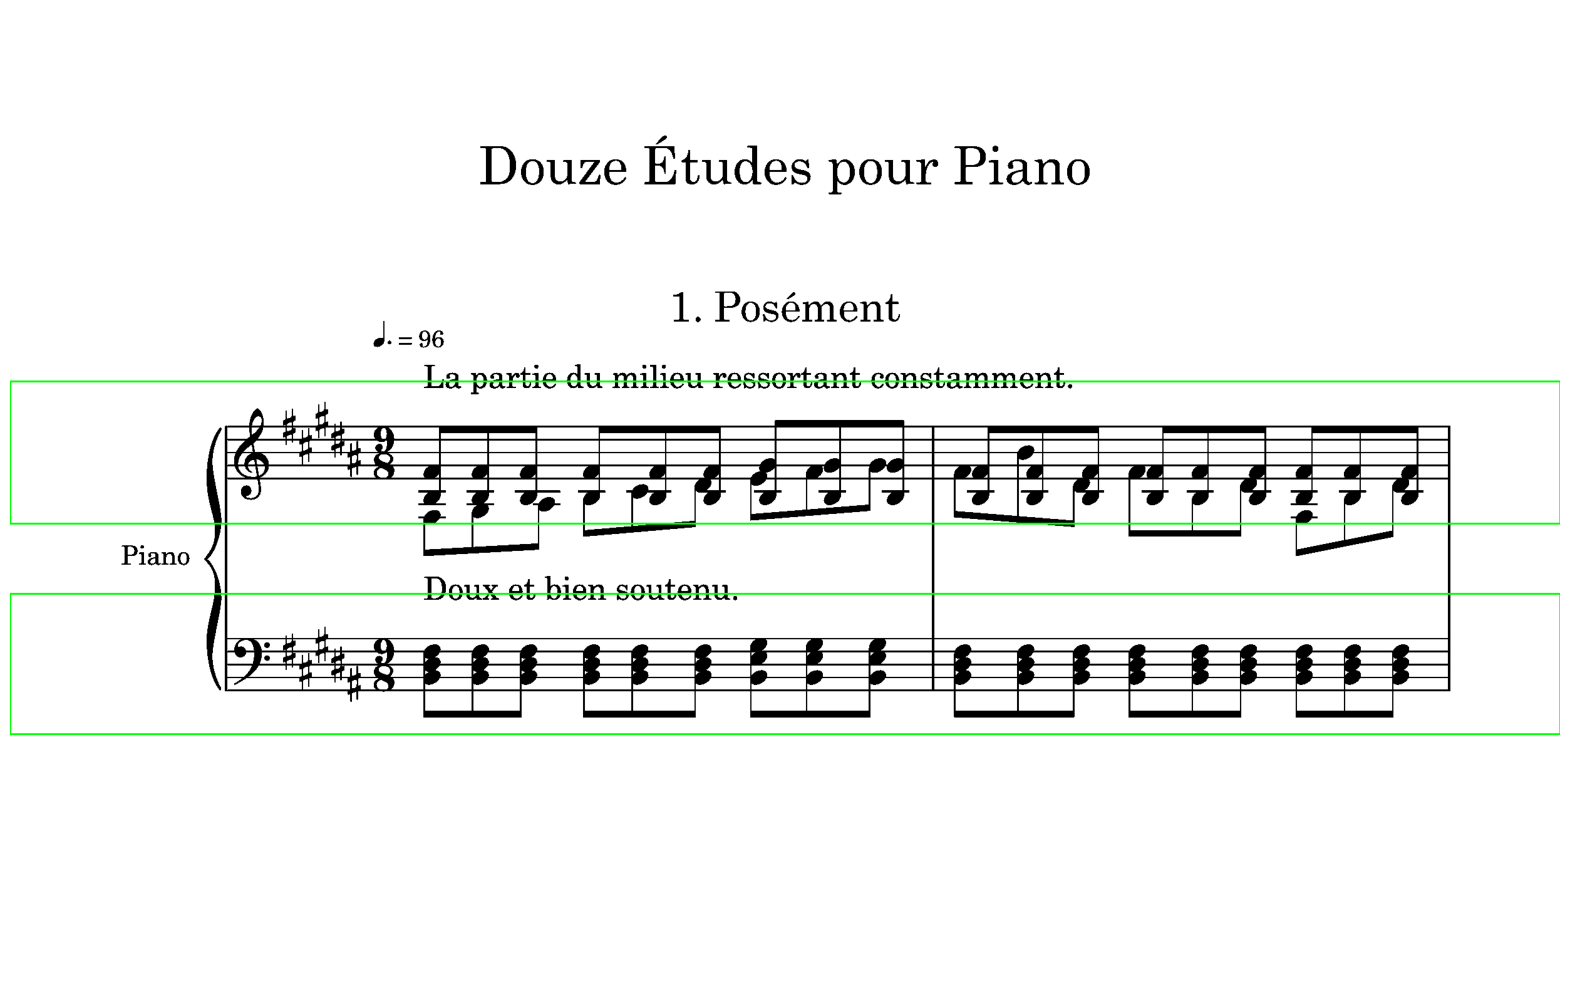

In [14]:
import cv2
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt

# Step 0: Convert grayscale
image_gray = cropped_image.convert("L")
image_np = np.array(image_gray)

# Step 1: Binarize image
_, binary = cv2.threshold(image_np, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Step 2: Horizontal projection
horizontal_projection = np.sum(binary, axis=1)

# Step 3: Detect staffline peaks
peaks, _ = find_peaks(horizontal_projection, height=np.max(horizontal_projection) * 0.5, distance=5)

# Step 4: Group into staves (5 lines per group)
grouped_staffs = []
for i in range(0, len(peaks) - 4, 5):
    group = peaks[i:i+5]
    grouped_staffs.append(group)

# Step 5: Convert grayscale to RGB for drawing
image_color = np.stack([image_np]*3, axis=-1)

# Step 6: Draw bounding boxes and print structured output
staff_bounds = []
staff_bounds = []
staff_objects = []

for i, group in enumerate(grouped_staffs):
    y_center = float(np.mean(group))
    unit_size = float(np.mean(np.diff(group)))
    padding = int(unit_size * 3.5)

    y_min = int(np.min(group) - padding)
    y_max = int(np.max(group) + padding)
    track = i % 2 + 1

    staff = Staff(
        center=y_center,
        upper_bound=y_min,
        lower_bound=y_max,
        unit_size=unit_size,
        track=track
    )
    staff_objects.append(staff)
    staff_bounds.append((y_min, y_max))

    cv2.rectangle(image_color, (0, y_min), (image_np.shape[1], y_max), (0, 255, 0), 2)
    print(staff)


# Step 7: Show image with bounding boxes
plt.figure(figsize=(20, 20))
plt.imshow(image_color)
plt.axis("off")
plt.show()

# Extracting First 200 One Staff Images

In [15]:
import re
import pprint

def natural_key(string):
    return [int(s) if s.isdigit() else s.lower() for s in re.split('(\d+)', string)]

#Sorts Images and Parsed_by_page_omr_xml directories
image_list = os.listdir(doremi_dir+ "Images")
omr_xml_list =  os.listdir(doremi_dir + "Parsed_by_page_omr_xml")
image_list.sort(key=natural_key)
omr_xml_list.sort(key=natural_key)

#Matches each .png file to their respective omr_xml file
image_to_omr = {img: omr for img, omr in zip(image_list, omr_xml_list)}
#pprint.pprint(image_to_omr)

In [16]:
def extract_staffs_from_image(cropped_image, padding_multiplier=4.5):
    image_gray = cropped_image.convert("L")
    image_np = np.array(image_gray)
    _, binary = cv2.threshold(image_np, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    horizontal_projection = np.sum(binary, axis=1)
    peaks, _ = find_peaks(horizontal_projection, height=np.max(horizontal_projection) * 0.5, distance=5)

    grouped_staffs = []
    for i in range(0, len(peaks) - 4, 5):
        group = peaks[i:i+5]
        grouped_staffs.append(group)

    staff_objects = []
    for i, group in enumerate(grouped_staffs):
        y_center = float(np.mean(group))
        unit_size = float(np.mean(np.diff(group)))
        padding = int(unit_size * padding_multiplier)

        y_min = int(np.min(group) - padding)
        y_max = int(np.max(group) + padding)
        track = i % 2 + 1

        staff = Staff(
            center=y_center,
            upper_bound=y_min,
            lower_bound=y_max,
            unit_size=unit_size,
            track=track
        )
        staff_objects.append(staff)

    return staff_objects

In [17]:
from PIL import Image
import os

single_track_images = []
staff_data_per_image = {}

for image_name in image_list:
    image_path = os.path.join(doremi_dir, "Images", image_name)
    try:
        cropped_image = Image.open(image_path)
        staff_objects = extract_staffs_from_image(cropped_image)

        tracks = set(s.track for s in staff_objects)
        if tracks == {1}:  # Only track 1
            single_track_images.append(image_name)
            staff_data_per_image[image_name] = staff_objects  # store staff info

        if len(single_track_images) == 200:
            break
    except Exception as e:
        print(f"Skipping {image_name} due to error: {e}")
        continue

# Confirm results
print(f"\nFound {len(single_track_images)} single-track images.\n")


Found 200 single-track images.



To help see what those 200 1 staff images we are going to use look like, (ALSO HELPS IF WE WANT TO FILTER OUT ANY INDIVIDUAL DATA OR IMAGES)

In [18]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# First 50 and last 50 images
first_single_200 = single_track_images

# cols = 5
# rows = (200 + cols - 1) // cols

# plt.figure(figsize=(20, rows * 4))

# for i, img_name in enumerate(first_single_200):
#     image_path = os.path.join(doremi_dir + "Images", img_name)
#     img = Image.open(image_path)
    
#     plt.subplot(rows, cols, i + 1)
#     plt.imshow(img, cmap="gray")
#     plt.title(img_name, fontsize=8)
#     plt.axis("off")

# plt.tight_layout()
# plt.show()

In [19]:
max_height = 0
max_image_name = None
max_upper = None
max_lower = None

for image_name in first_single_200:
    image_path = os.path.join(doremi_dir + "Images", image_name)
    cropped_image = Image.open(image_path)

    staff_objects = extract_staffs_from_image(cropped_image)
    #print(staff_objects)
    if max_upper == None or staff_objects[0].upper_bound < max_upper:
        max_upper = staff_objects[0].upper_bound
    if max_lower == None or staff_objects[0].lower_bound > max_lower:
        max_lower = staff_objects[0].lower_bound

print(f"Upper bound: {max_upper}")
print(f"Lower bound: {max_lower}")

Upper bound: 319
Lower bound: 842


# OMR_XML Preprocessng

In [20]:
import re
import pprint

def natural_key(string):
    return [int(s) if s.isdigit() else s.lower() for s in re.split('(\d+)', string)]

#Sorts Images and Parsed_by_page_omr_xml directories
image_list = os.listdir(doremi_dir+ "Images")
omr_xml_list =  os.listdir(doremi_dir + "Parsed_by_page_omr_xml")
image_list.sort(key=natural_key)
omr_xml_list.sort(key=natural_key)

#Matches each .png file to their respective omr_xml file
image_to_omr = {img: omr for img, omr in zip(image_list, omr_xml_list)}
#pprint.pprint(image_to_omr)


In [21]:
#To view an image [0,5217]
key_list = list(image_to_omr.keys())
image_path = os.path.join(doremi_dir, "Images", key_list[5217])
image = Image.open(image_path)
#image

In [22]:
class Note:
    def __init__(self, class_name: str, top: int, left: int, width: int, height: int):
        self.class_name = class_name
        self.top = top
        self.left = left
        self.width = width
        self.height = height
    def gather_coordinates(self):
        return [self.top, self.left, self.width, self.height]
    def create_box(self):
        return [(self.left, self.top), (self.left + self.width, self.top + self.height)]

In [23]:
import xml.etree.ElementTree as ET

image_to_notes = {}
for key in key_list:
# Parse the XML file
    xml_path = os.path.join(doremi_dir, "Parsed_by_page_omr_xml", image_to_omr[key])
    tree = ET.parse(xml_path) 
    root = tree.getroot()
# Define target classnames
    target_classes = {'noteheadBlack', 'noteheadHalf', 'noteheadWhole'}

# Collect matching nodes
    matching_nodes = []

# Loop through all <Node> elements
    for node in root.findall('.//Node'):
        class_name = node.find('ClassName')
        if class_name is not None and class_name.text in ('noteheadBlack', 'noteheadHalf', 'noteheadWhole'):
            matching_nodes.append(node)


# Print results
    final_notes = []
    for match in matching_nodes:
        note = Note(match.find("ClassName").text, int(match.find("Top").text), int(match.find("Left").text), int(match.find("Width").text), int(match.find("Height").text))
        final_notes.append(note)
    image_to_notes[key] = final_notes
#pprint.pprint(image_to_notes)

In [24]:
first_200_image_to_notes = {key: image_to_notes[key] for key in first_single_200 if key in image_to_notes}

top = max_upper
bottom = max_lower
 
cropped_note_pairs = []
for i, img_name in enumerate(first_200_image_to_notes.keys()):
    image_path = os.path.join(doremi_dir + "Images", img_name)
    img = Image.open(image_path)
    width = img.width
    # Crop image to vertical slice (top to bottom)
    cropped = img.crop((0, top, width, bottom))
    image_notes = image_to_notes[img_name]
    for note in image_notes:
        note.top -= max_upper
    cropped_note_pairs.append((cropped, image_notes))

In [25]:
from PIL import Image, ImageDraw

#pprint.pprint(cropped_note_pairs)
# for i in range(200):
#     test_image, notes = cropped_note_pairs[i]
#     img = test_image.copy()  
#     draw = ImageDraw.Draw(img)

#     # Draw bounding boxes on the image
#     counter = 0;
#     for note in notes:
#         draw.rectangle(note.create_box(), outline="red", width=2)
#         draw.text(note.create_box()[1], str(counter), fill="black")
#         counter += 1
#     display(img)
#     width, height = img.size
#     print(width)
#     print(height)

test_image, notes = cropped_note_pairs[0]
img = test_image.copy()  
sample_cropped_img = test_image

# Notehead Extraction

## Morphing

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 

WIDTH_FACTOR = 0.5
HEIGHT_FACTOR = 0.4
MIN_AREA = 150 # pixels

MAX_HEIGHT_WIDTH_RATIO = 2.0
MIN_WIDTH_HEIGHT_RATIO = 0.5  

def remove_staff_lines(binary_img: np.ndarray) -> np.ndarray:
    """
    Detect and remove horizontal staff lines from the binary image input. 

    Output: 
        np.ndarray: a binary image with horizontal staff lines removed.
    """
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40,1))
    detected_stafflines = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
    return cv2.subtract(binary_img, detected_stafflines)

def extract_noteheads(img_path, debug: bool, ellipse_size: int) -> np.ndarray:
    # convert image to grayscale
    # img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # testing with 'cropped_img' variable
    gray_img = img_path.convert('L')
    gray_img = np.array(gray_img, dtype=np.uint8)

    # assign all pixel values higher than 127 to 255 and others to 0
    _, binary_img = cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY_INV)
    
    if debug:
        plt.figure(figsize=(6,6))
        plt.imshow(binary_img, cmap='gray')
        plt.title("Binary Inverted")
        plt.axis('off')
        plt.show()
        
    # remove staff lines
    processed_img = remove_staff_lines(binary_img)

    # Performing morphological operations
    w_close = max(1, int(round(ellipse_size * 0.2)))
    h_close = max(1, int(round(ellipse_size * 0.4)))
    close_krn = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (w_close, h_close))
    closed    = cv2.morphologyEx(processed_img, cv2.MORPH_CLOSE, close_krn)

    if debug:
        plt.figure(figsize=(6,6))
        plt.imshow(closed, cmap='gray')
        plt.title("After Closed")
        plt.axis('off')
        plt.show()
           
    notehead_size = (
        int(round(ellipse_size * WIDTH_FACTOR)),
        int(round(ellipse_size * HEIGHT_FACTOR))
    )
    
    # erode away isolated pixels that are not note heads
    kernel_2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, notehead_size)
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel_2)

    if debug:
        plt.figure(figsize=(6,6))
        plt.imshow(opened, cmap='gray')
        plt.title("After Opened")
        plt.axis('off')
        plt.show()

    # find contours
    contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if debug:
        canvas = cv2.cvtColor(opened, cv2.COLOR_GRAY2BGR)
        
        cv2.drawContours(canvas, contours, -1, (0,255,0), 1)
        
        plt.figure(figsize=(6,6))
        plt.imshow(canvas[...,::-1])
        plt.title(f'{len(contours)} contours found')
        plt.axis('off')
        plt.show()

    # filter out shapes that are not noteheads by checking how round the white area is
    notehead_mask = np.zeros_like(opened)
    for item in contours:
        area = cv2.contourArea(item)
        # print(area)
        if area < MIN_AREA:
            continue
            
        x, y, w, h = cv2.boundingRect(item)
        
        # Drop any blob that's too tall/thin:
        if h / float(w) > MAX_HEIGHT_WIDTH_RATIO:
            continue

        # Drop any blob that's too wide/flat:
        if w / float(h) < MIN_WIDTH_HEIGHT_RATIO:
            continue
            
        cv2.drawContours(notehead_mask, [item], -1, 255, -1)

    morphed = notehead_mask

    if debug:
        plt.figure(figsize=(6,6))
        plt.imshow(morphed, cmap='gray')
        plt.title("Morphed (staff lines out, noteheads closed)")
        plt.axis('off')
        plt.show()
        
    final_contours, _ = cv2.findContours(
        notehead_mask,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )

    return morphed, final_contours

In [27]:
def split_blob(mask):
    # mask: one over‐merged contour (255 inside)
    dist = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
    _, fg = cv2.threshold(dist, 0.4*dist.max(), 255, cv2.THRESH_BINARY)
    fg = fg.astype(np.uint8)

    # markers: sure background vs foreground
    nlab, markers = cv2.connectedComponents(fg)
    markers = markers + 1
    unknown = cv2.subtract(mask, fg)
    markers[unknown==255] = 0

    # watershed
    color = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    cv2.watershed(color, markers)
    
    # extract each piece
    pieces = []
    for lab in range(2, nlab+2):
        piece = np.zeros_like(mask)
        piece[markers==lab] = 255
        if cv2.countNonZero(piece)>0:
            pieces.append(piece)
    return pieces


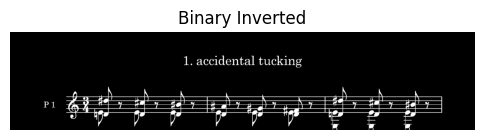

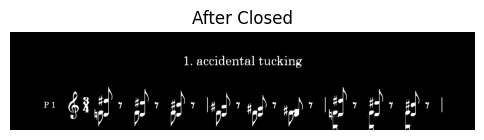

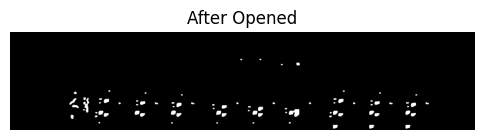

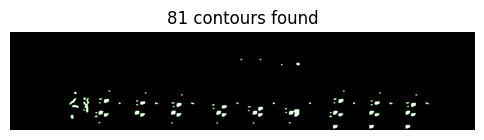

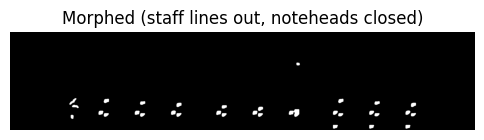

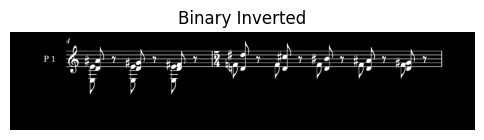

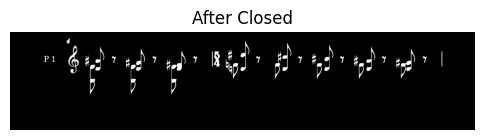

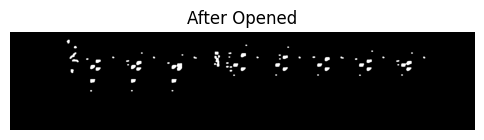

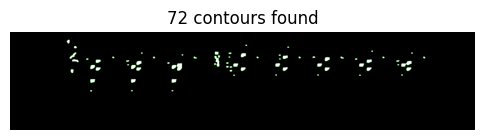

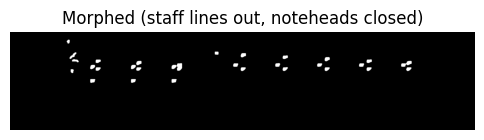

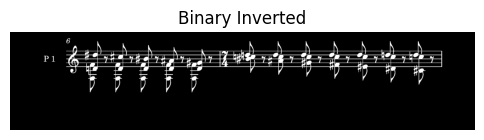

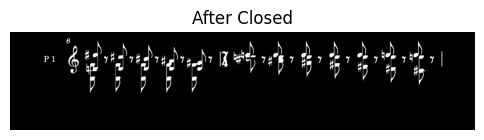

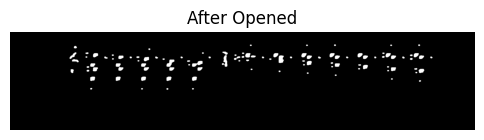

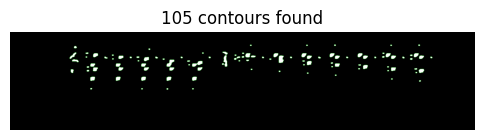

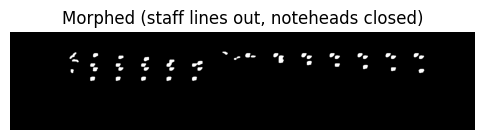

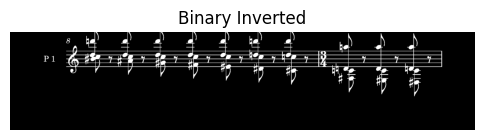

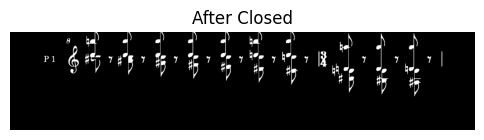

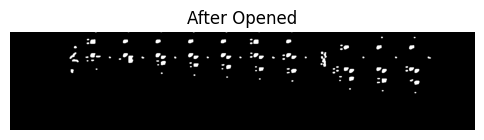

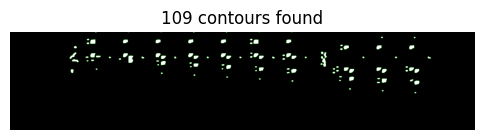

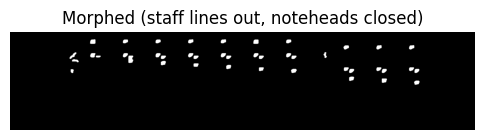

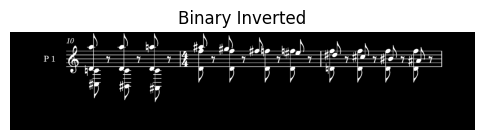

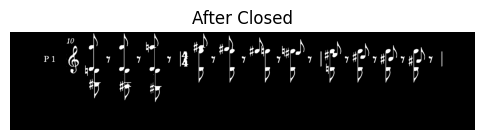

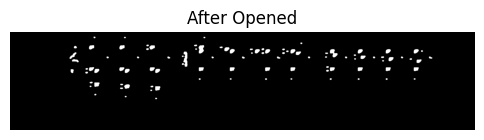

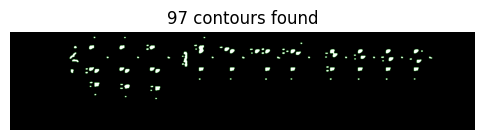

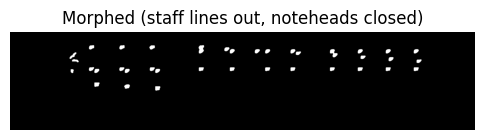

In [28]:
img_contours = []
for i in range(5):
    test_image, notes = cropped_note_pairs[i]    
    morphed, contours = extract_noteheads(test_image, True, 20.5)
    img_contours.append(contours)

In [59]:
import cv2
import numpy as np

def refine_and_fit_ellipses(gray_img, notehead_mask, contours,
                            pad=4,
                            iou_thresh=0.75,
                            min_area=200,
                            min_ellipse_area=300,
                            min_minor_axis=10,
                            min_axis_ratio=0.5,
                            min_area_ratio=0.6,
                            max_area_ratio=1.3,
                            min_solidity=0.75,
                            debug=False):
    """
    Returns two lists:
     - accepted: [( (cx,cy), (MA,ma), angle ), ... ]
     - rejected: [ ( (cx,cy), reason_string ), ... ]
    """
    H, W = gray_img.shape
    accepted, rejected = [], []
    MAX_AREA = 500

    for cnt in contours:
        # Computing the raw area
        rawA = cv2.contourArea(cnt)
        blob = np.zeros_like(notehead_mask)
        cv2.drawContours(blob, [cnt], -1, 255, -1)
        
        if debug:
            x,y,w,h = cv2.boundingRect(cnt)
            x0, y0 = max(0, x-pad), max(0, y-pad)
            x1, y1 = x + w + pad, y + h + pad
            
            plt.figure(figsize=(4,4))
            plt.imshow(blob[y0:y1, x0:x1],
                       cmap='gray',
                       vmin=0, vmax=255,
                       interpolation='nearest')
            plt.title("Blob mask (zoomed)")
            plt.axis('off')

        # If raw area is bigger than the max area, split into multple blobs
        if rawA > MAX_AREA:
            submasks = split_blob(blob)
        else:
            submasks = [blob]

        for piece in submasks:
            # extracting pieces from the submask and adding padding 
            x_p,y_p,w_p,h_p = cv2.boundingRect(cnt)
            x0, y0 = max(0,x_p-pad), max(0,y_p-pad)
            x1, y1 = min(W,x_p+w_p+pad), min(H,y_p+h_p+pad)

            roi_gray = gray_img[y0:y1, x0:x1]
            roi_mask = piece[y0:y1, x0:x1]
            
            if debug:
                plt.figure(figsize=(4,4))
                plt.imshow(roi_gray,
                           cmap='gray',
                           vmin=0, vmax=255,
                           interpolation='nearest')
                plt.title("ROI gray")
                plt.axis('off')
                
                plt.figure(figsize=(4,4))
                plt.imshow(roi_mask,
                           cmap='gray',
                           vmin=0, vmax=255,
                           interpolation='nearest')
                plt.title("ROI mask")
                plt.axis('off')
                
            # finding the local contours within the mask
            local_cnts, _ = cv2.findContours(
            roi_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
            )

            # Run 9 total tests
            for lc in local_cnts:
                area = cv2.contourArea(lc)
                cx_loc = cy_loc = MA = ma = ang = None

                # 1) raw-area floor
                if area < min_area:
                    cx_loc, cy_loc = cv2.boundingRect(lc)[:2]
                    rejected.append(((cx_loc,y0+cy_loc), "contour area<min_area"))
                    continue

                # 2) need at least 5 points to fit an ellipse
                if len(lc) < 5:
                    cx_loc, cy_loc = cv2.boundingRect(lc)[:2]
                    rejected.append(((cx_loc,y0+cy_loc), "too few points"))
                    continue

                # 3) fit the ellipse
                (cx_loc, cy_loc), (MA, ma), ang = cv2.fitEllipse(lc)

                # 4) ellipse-area floor
                ell_area = np.pi*(MA/2)*(ma/2)
                if ell_area < min_ellipse_area:
                    rejected.append(((cx_loc+x0, cy_loc+y0), f"ell_area={ell_area:.0f}<min"))
                    continue

                # 5) minor-axis floor
                if min(MA, ma) < min_minor_axis:
                    rejected.append(((cx_loc+x0, cy_loc+y0), f"minor_axis={min(MA,ma):.1f}<min"))
                    continue

                # 6) axis-ratio
                axis_r = min(MA,ma)/max(MA,ma)
                if axis_r < min_axis_ratio:
                    rejected.append(((cx_loc+x0, cy_loc+y0), f"axis_ratio={axis_r:.2f}<min"))
                    continue

                # 7) area-ratio
                area_r = area/ell_area
                if not (min_area_ratio <= area_r <= max_area_ratio):
                    rejected.append(((cx_loc+x0, cy_loc+y0), f"area_ratio={area_r:.2f}"))
                    continue

                # 8) solidity
                hull = cv2.convexHull(lc)
                hull_area = cv2.contourArea(hull)
                solidity = area/hull_area if hull_area>0 else 0
                if solidity < min_solidity:
                    rejected.append(((cx_loc+x0, cy_loc+y0), f"solidity={solidity:.2f}<min"))
                    continue

                # 9) IoU
                ell_mask = np.zeros_like(roi_mask)
                cv2.ellipse(ell_mask, ((cx_loc,cy_loc),(MA,ma),ang),
                        color=255, thickness=-1)
                inter = np.logical_and(roi_mask>0, ell_mask>0).sum()
                union= np.logical_or (roi_mask>0, ell_mask>0).sum()
                iou = inter/union if union>0 else 0
                if iou < iou_thresh:
                    rejected.append(((cx_loc+x0, cy_loc+y0), f"IoU={iou:.2f}<thr"))
                    continue

                # if we get here, it’s a keeper
                accepted.append(((cx_loc+x0, cy_loc+y0),(MA,ma),ang))

    return accepted, rejected

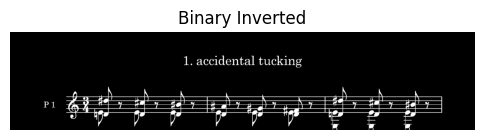

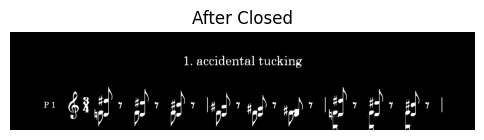

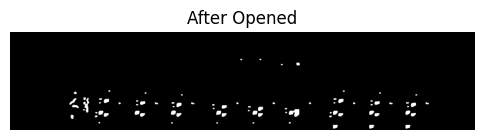

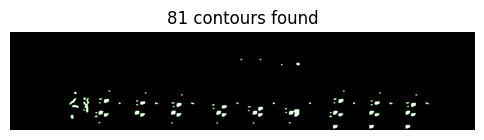

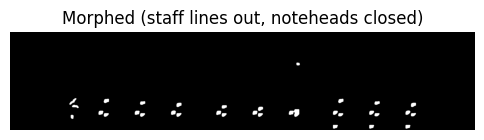

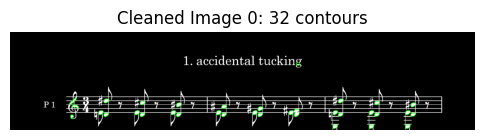

/tmp/ipykernel_31/1547414821.py:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(4,4))


Accepted: 29 ellipses
Rejected: 4 blobs


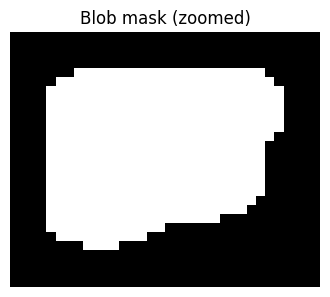

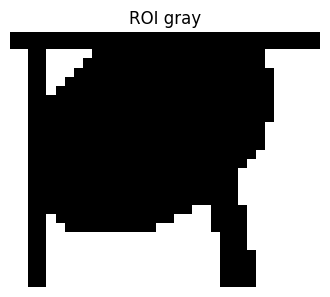

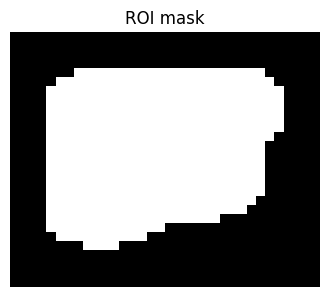

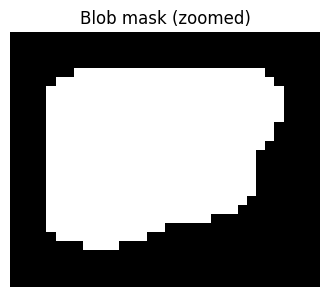

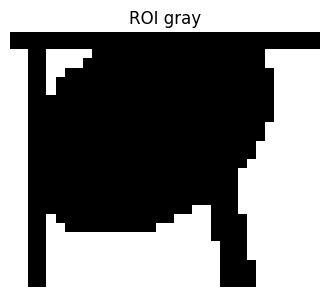

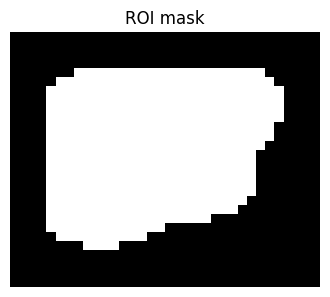

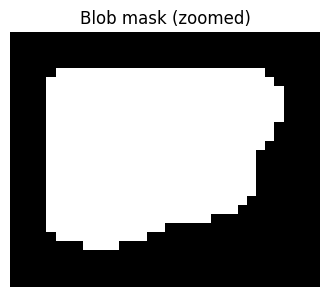

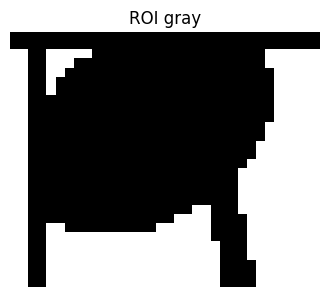

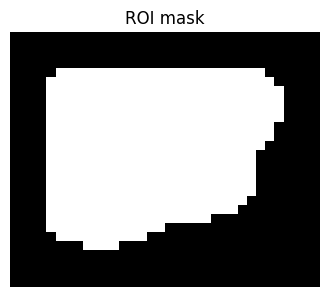

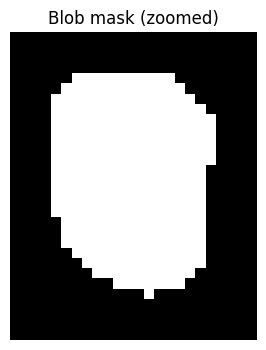

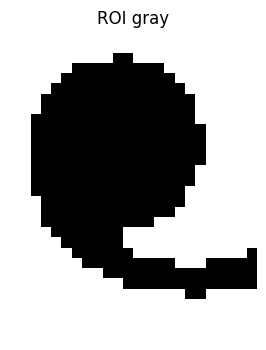

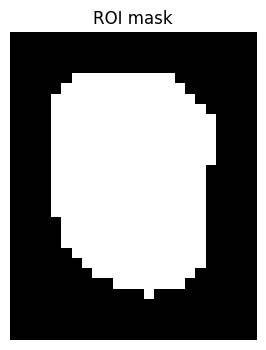

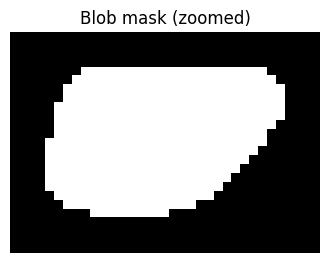

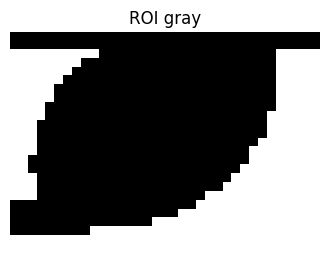

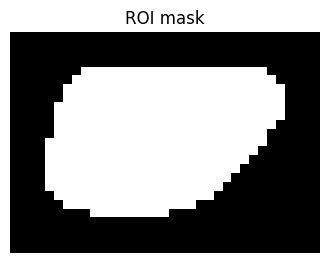

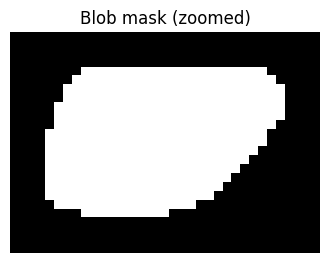

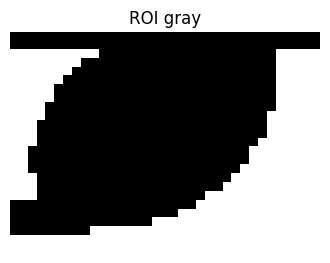

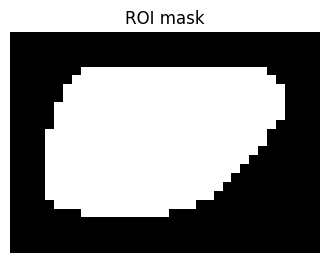

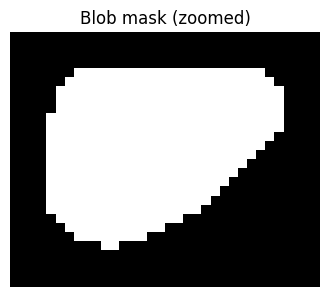

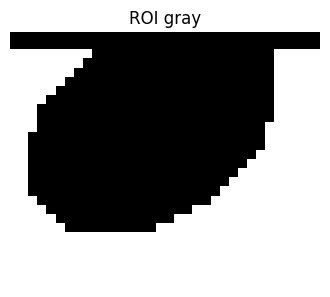

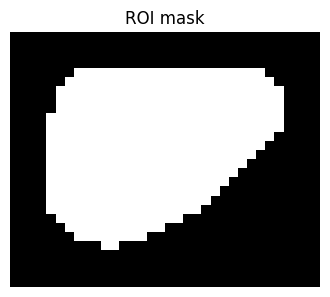

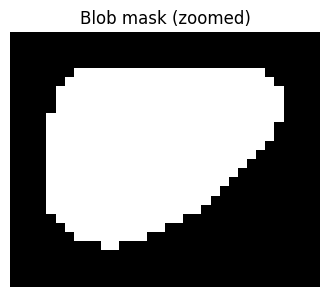

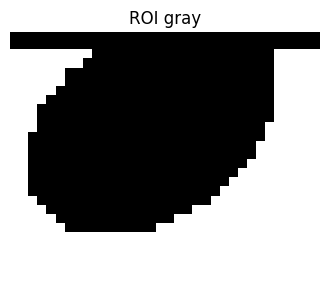

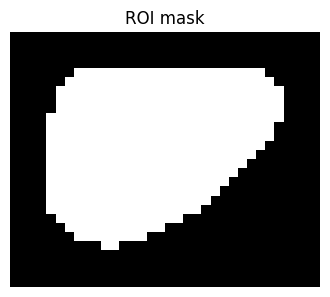

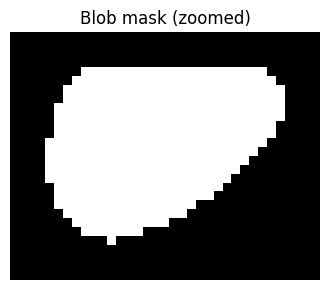

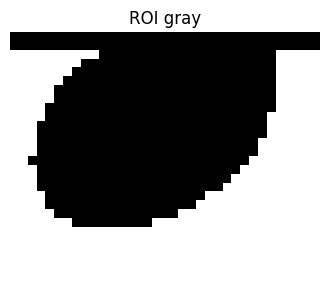

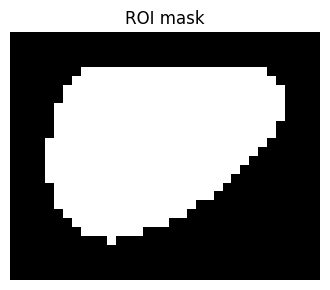

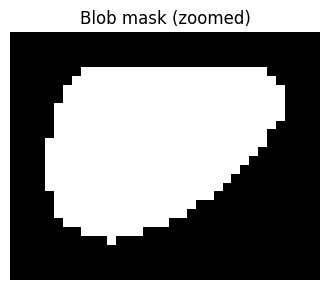

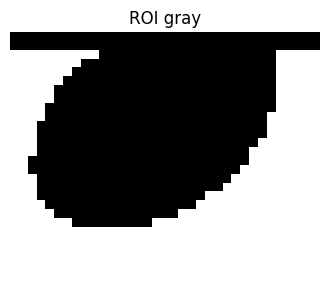

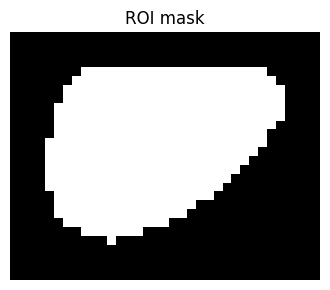

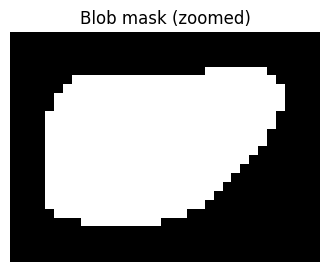

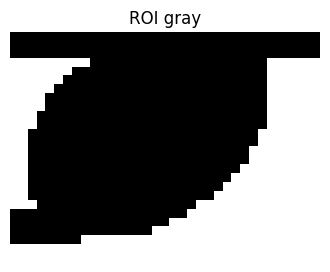

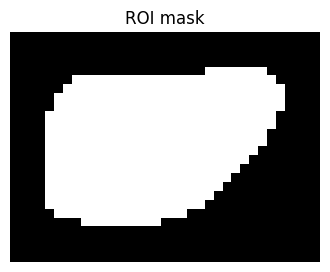

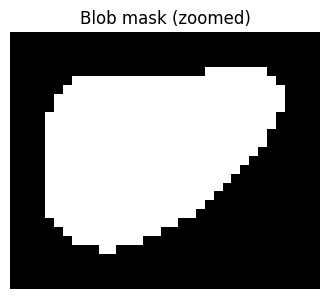

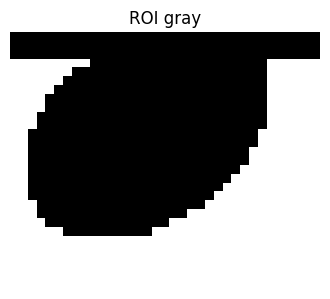

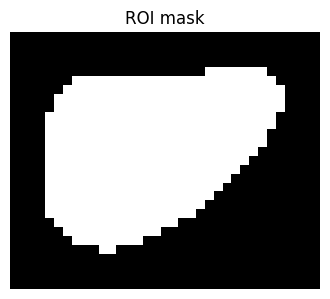

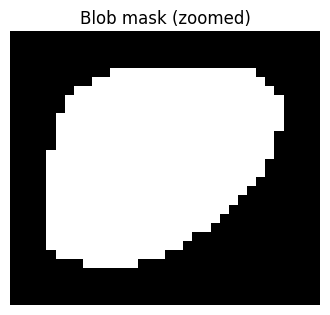

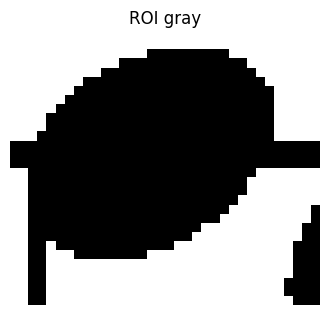

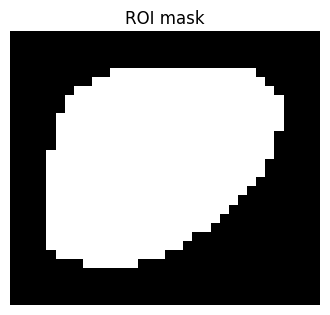

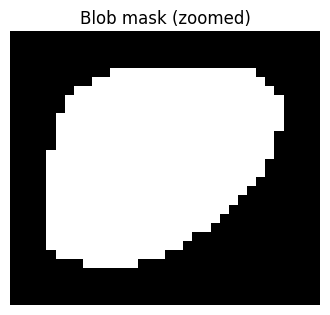

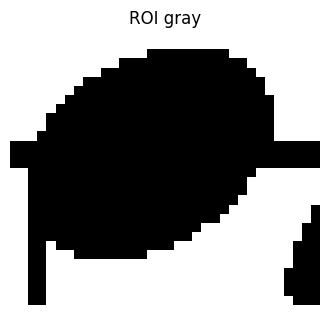

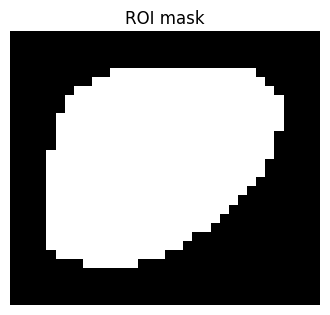

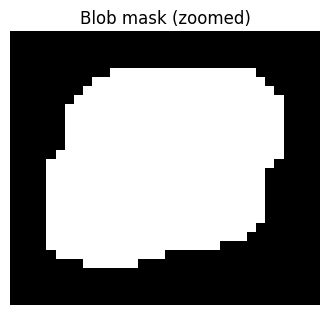

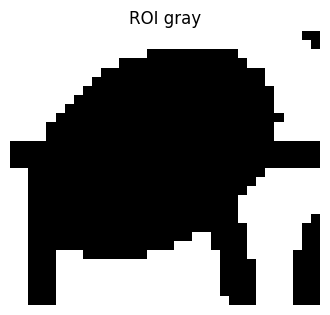

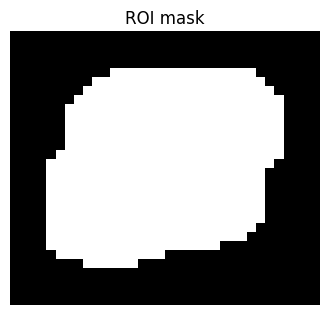

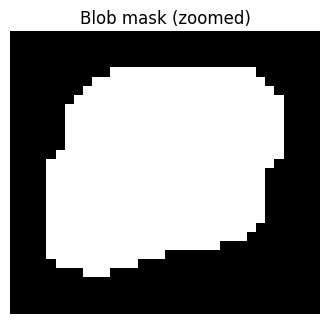

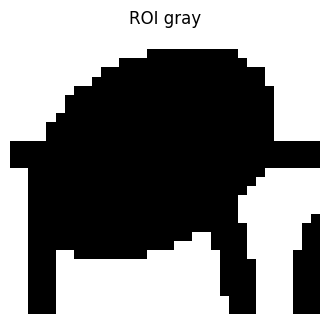

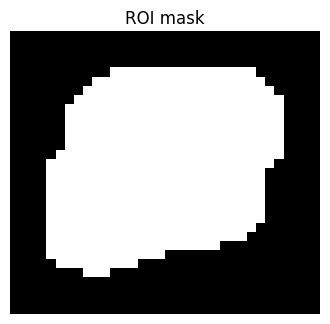

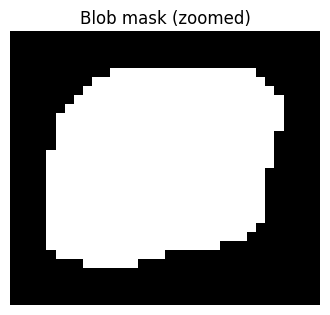

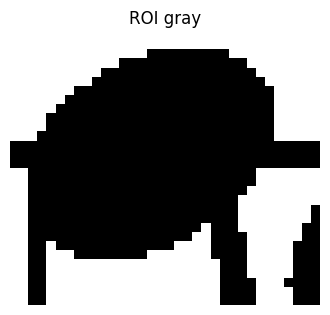

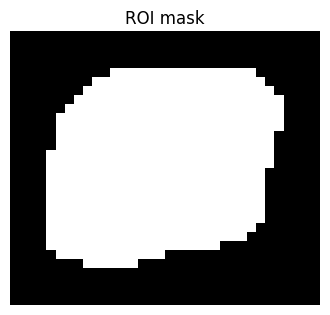

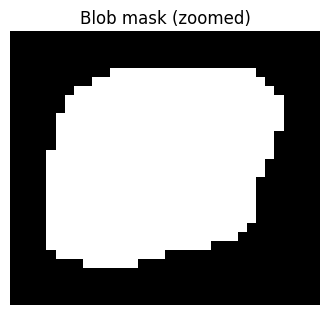

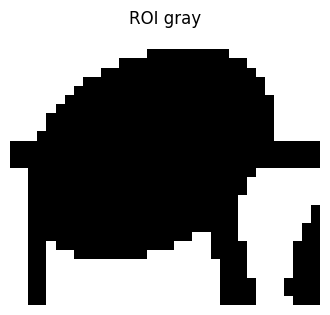

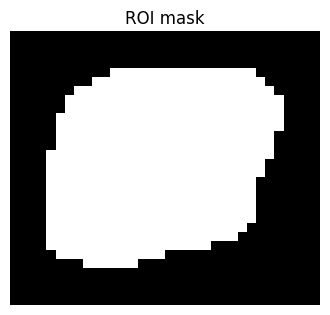

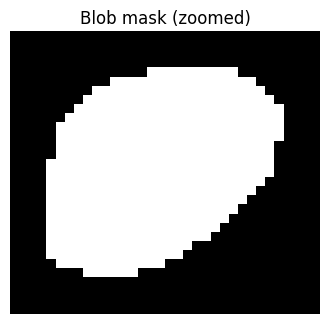

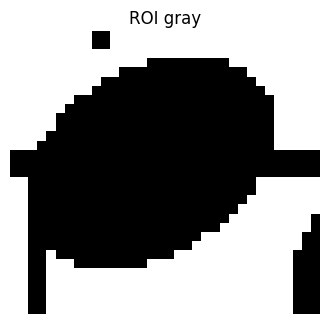

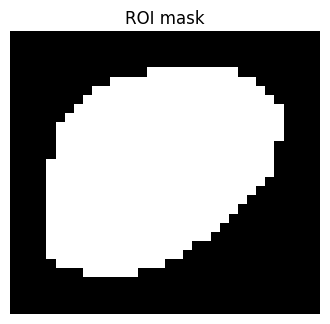

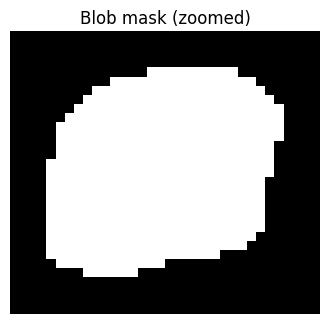

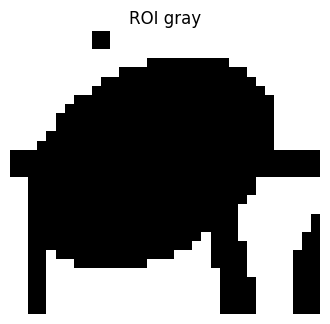

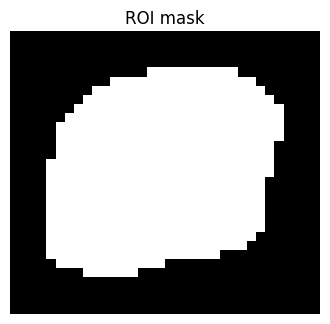

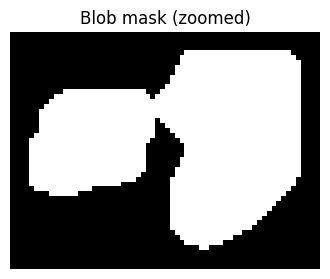

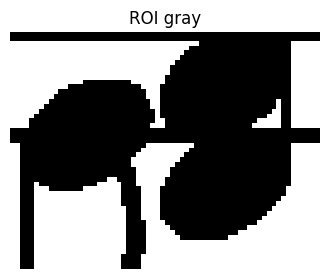

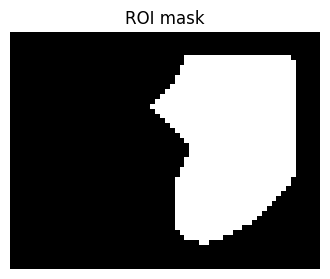

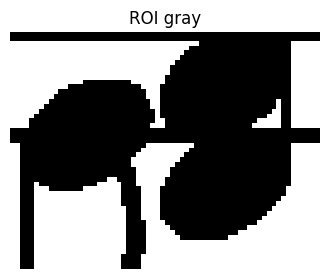

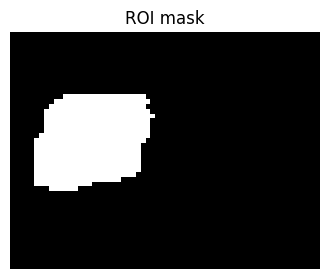

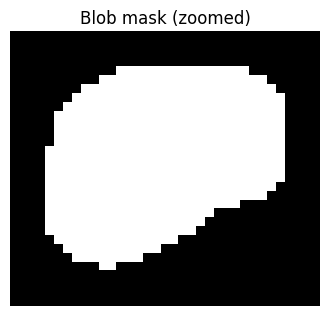

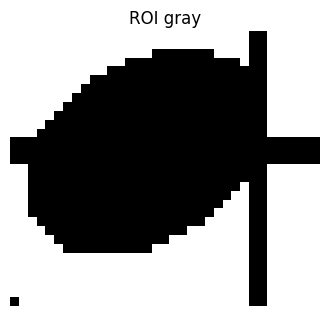

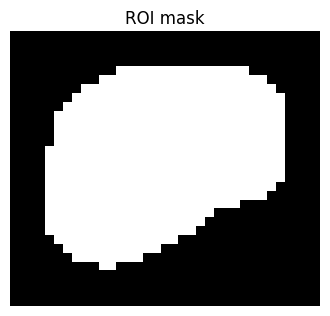

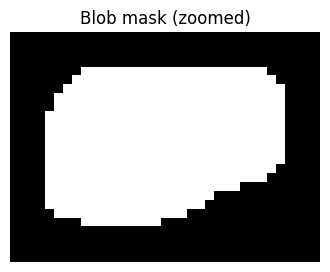

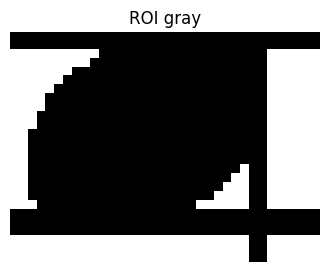

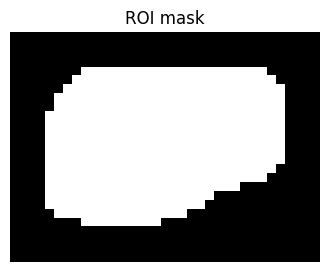

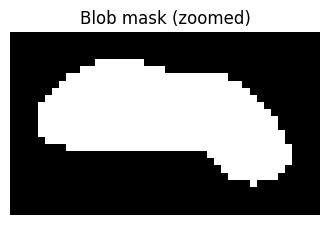

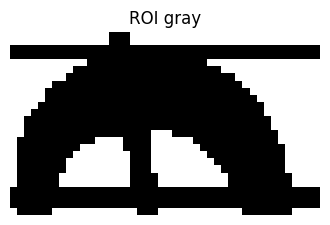

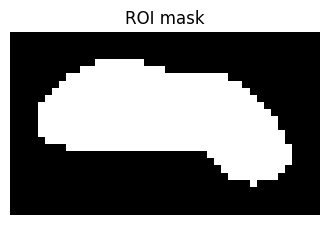

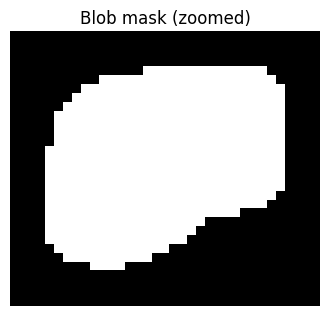

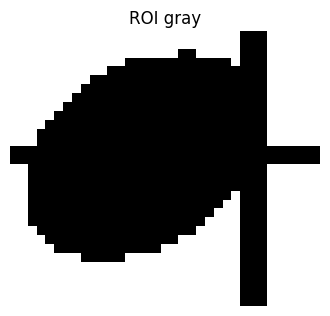

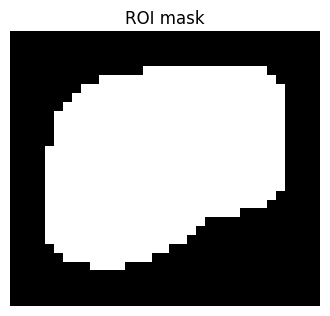

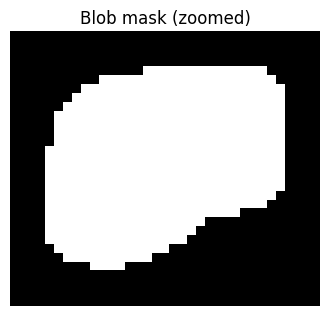

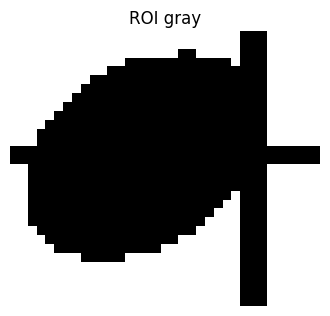

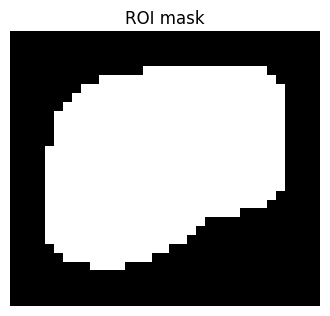

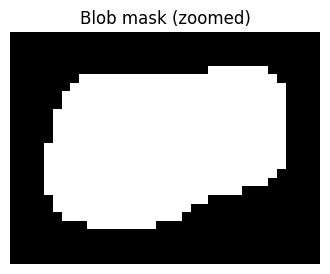

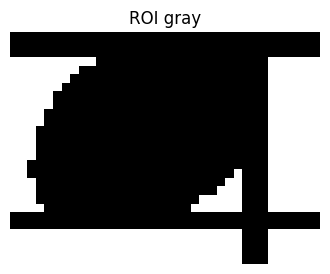

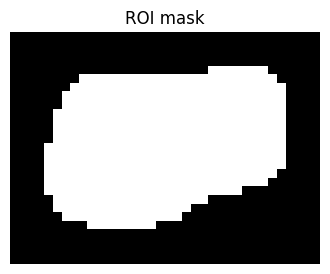

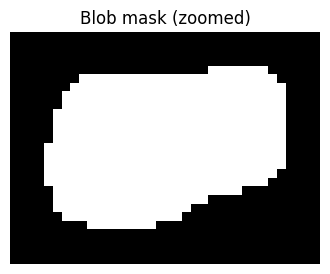

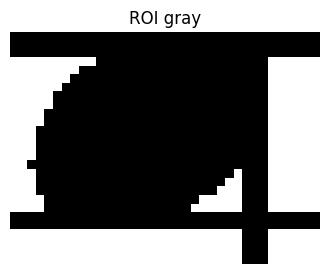

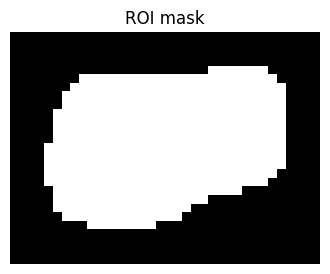

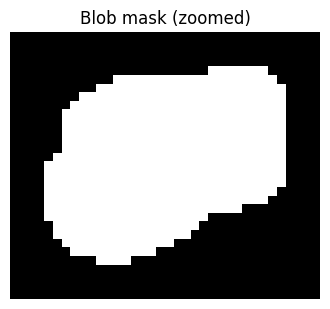

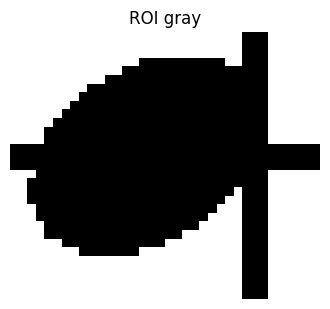

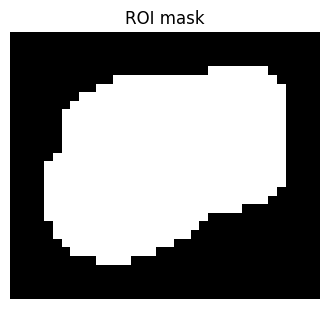

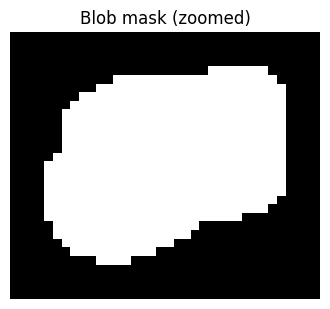

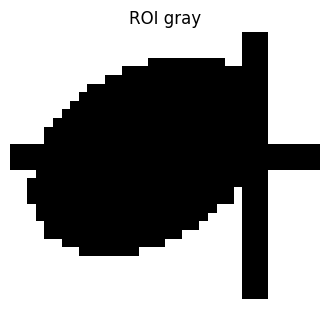

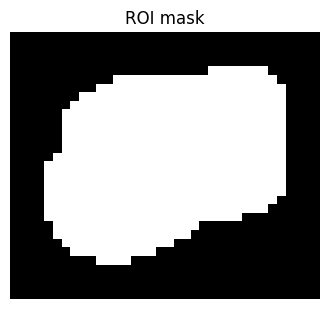

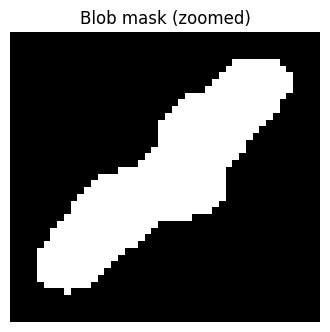

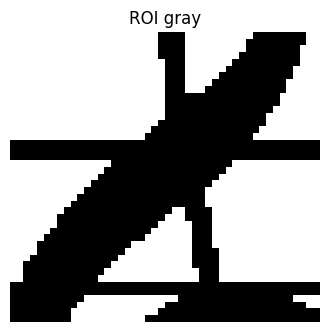

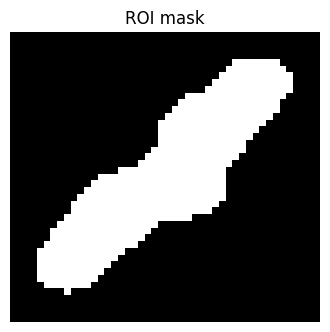

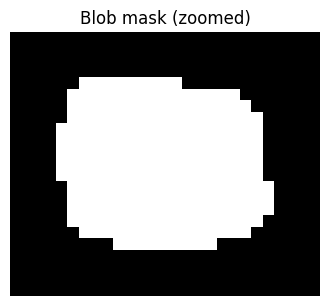

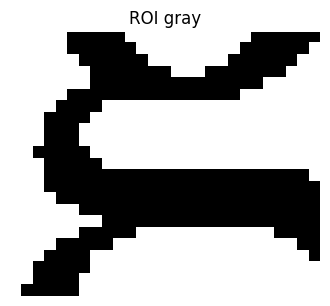

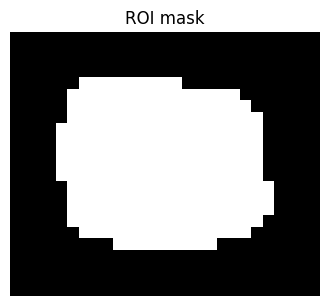

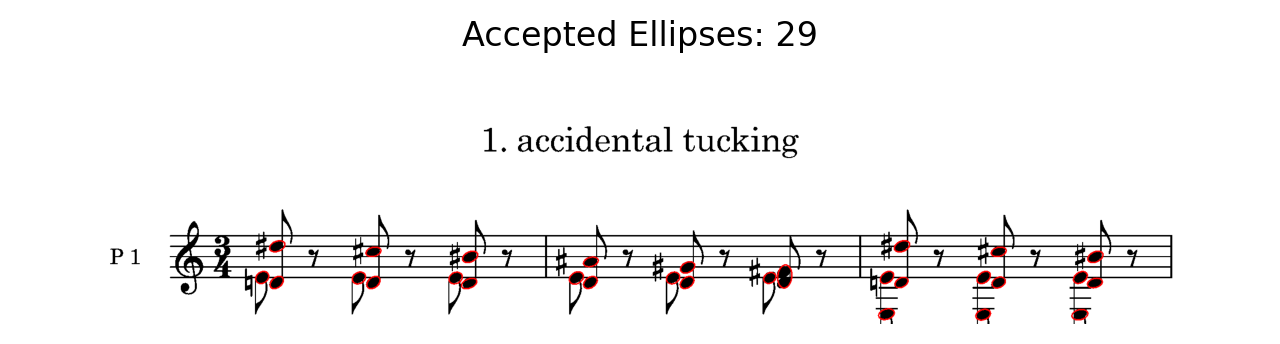

In [60]:
 for i in range(1):
    test_img, notes = cropped_note_pairs[i]

    # 1) Make image gray & binary
    if not isinstance(test_img, np.ndarray):
        gray = np.array(test_img.convert('L'), dtype=np.uint8)
    else:
        gray = test_img.astype(np.uint8)

    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

    # 2) Extract noteheads
    morphed, contours = extract_noteheads(
        test_img,
        ellipse_size=20,
        debug=True
    )

    # 3) Visualize the cleaned contours
    canvas = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(canvas, contours, -1, (0,255,0), 2)
    plt.figure(figsize=(6,6))
    plt.imshow(canvas[..., ::-1])
    plt.title(f"Cleaned Image {i}: {len(contours)} contours")
    plt.axis('off')
    plt.show()

    # 4) Now call the new fitter
    accepted, rejected = refine_and_fit_ellipses(
        gray_img = gray,
        notehead_mask = morphed,
        contours = contours,
        pad = 4,
        iou_thresh = 0.75,
        min_area = MIN_AREA,
        debug = True
    )
    
    print(f"Accepted: {len(accepted)} ellipses")
    # for idx,(c,a,ang) in enumerate(accepted):
    #     print(f"  #{idx}: center={c}, axes={a}, angle={ang:.1f}")

    print(f"Rejected: {len(rejected)} blobs")
    # for idx,(center,reason) in enumerate(rejected):
    #     print(f"  #{idx}: at {center} → {reason}")

    # 5) (Optional) overlay the kept ellipses on your original
    canvas2 = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    for (cx,cy), (MA,ma), ang in accepted:
        cv2.ellipse(
            canvas2,
            (int(round(cx)), int(round(cy))),
            (int(round(MA/2)), int(round(ma/2))),
            angle=ang,
            startAngle=0,
            endAngle=360,
            color=(0,0,255),
            thickness=2
        )
    plt.figure(figsize=(8,8), dpi=200)
    plt.imshow(canvas2[..., ::-1])
    plt.title(f"Accepted Ellipses: {len(accepted)}")
    plt.axis('off')
    plt.show()


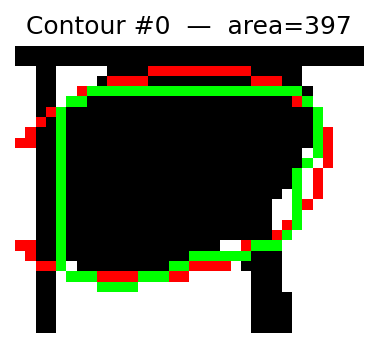

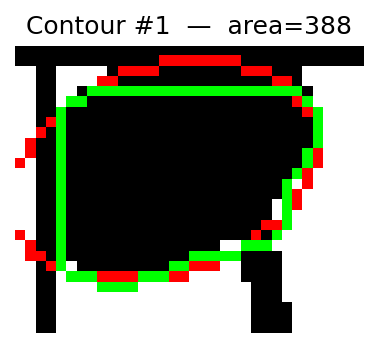

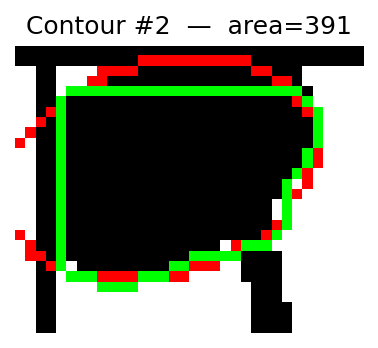

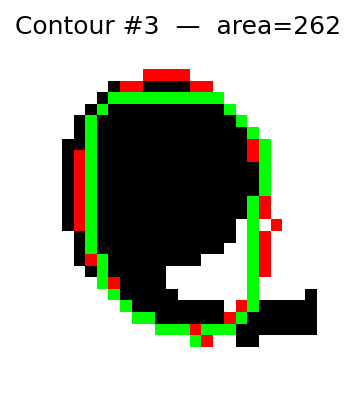

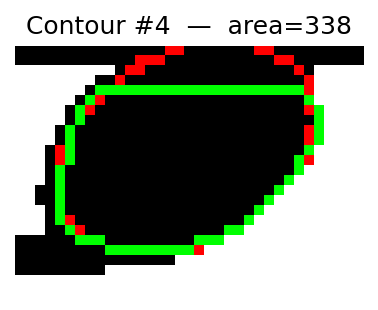

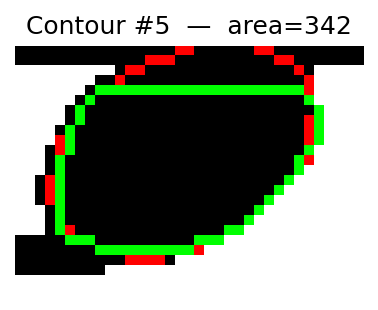

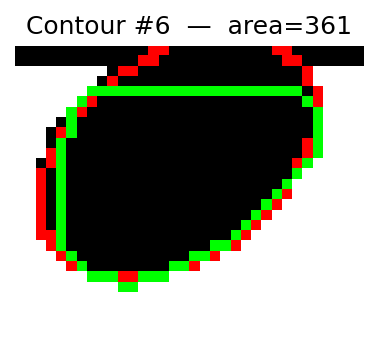

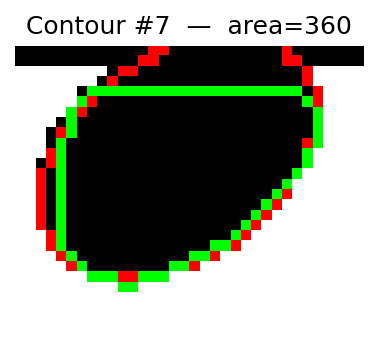

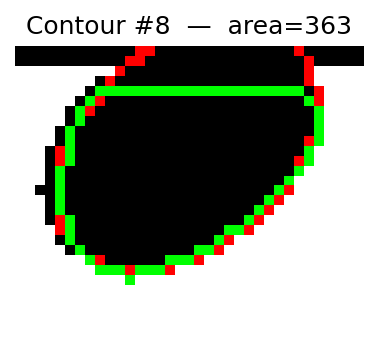

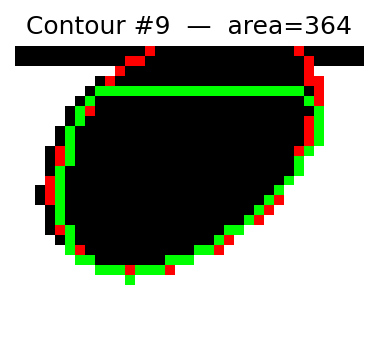

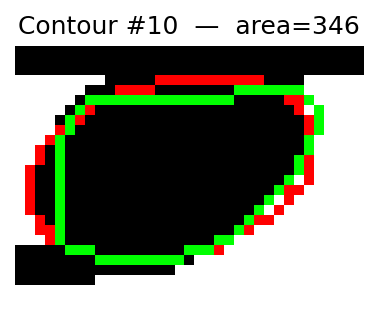

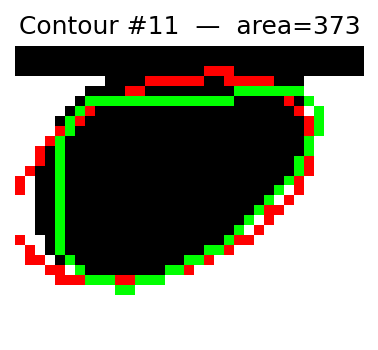

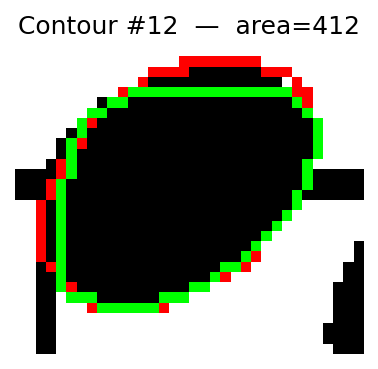

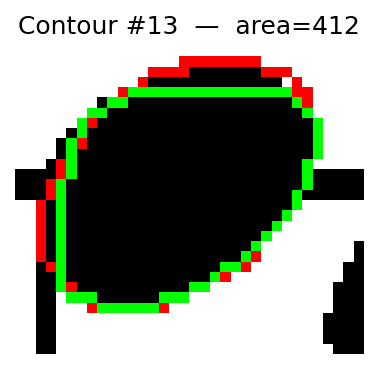

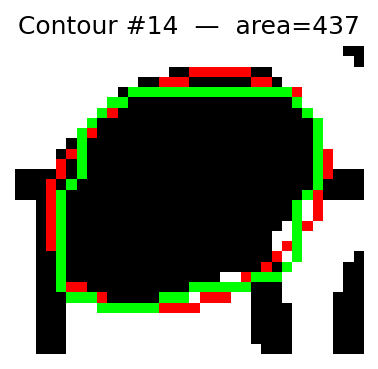

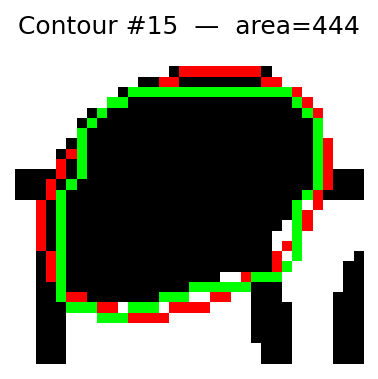

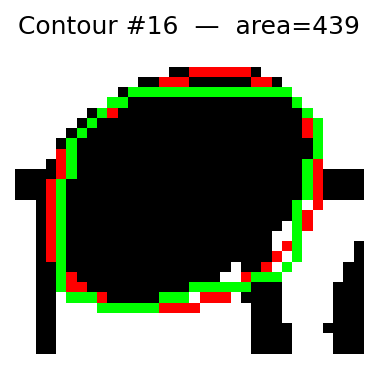

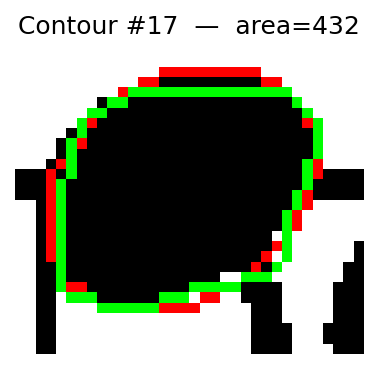

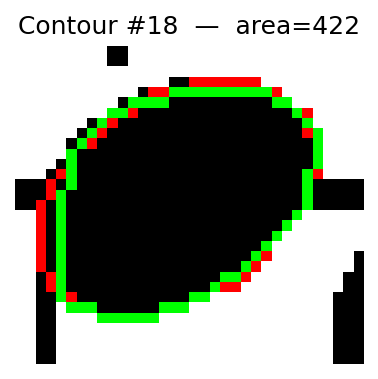

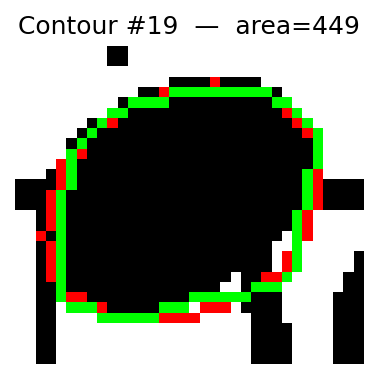

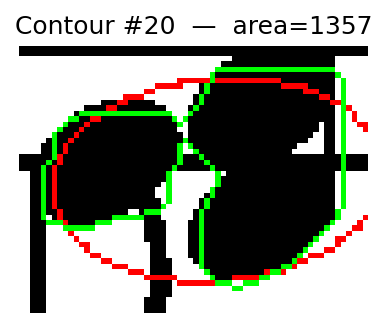

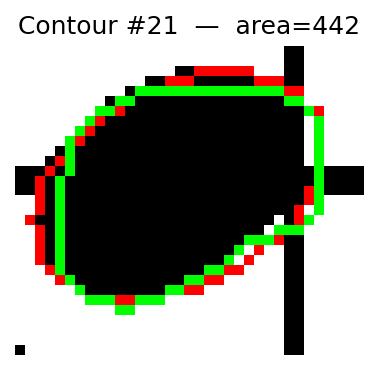

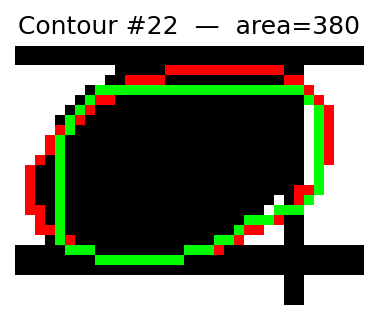

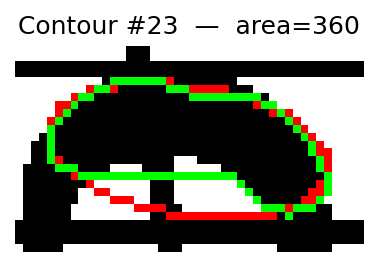

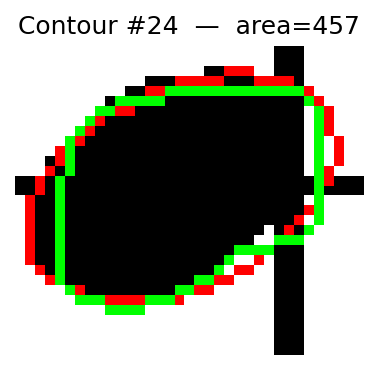

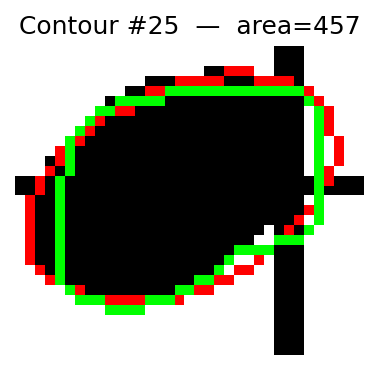

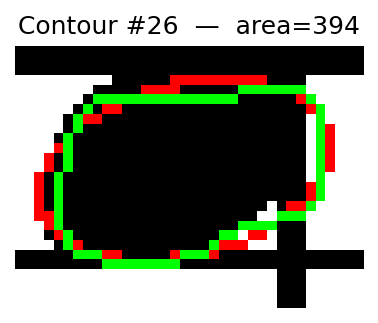

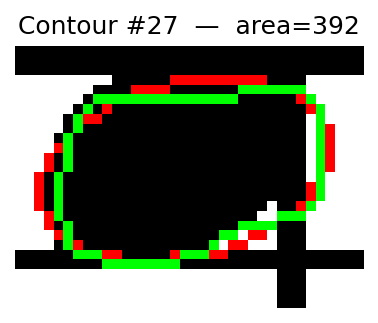

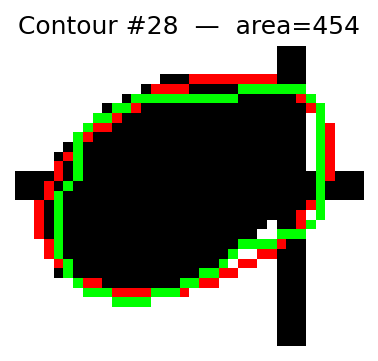

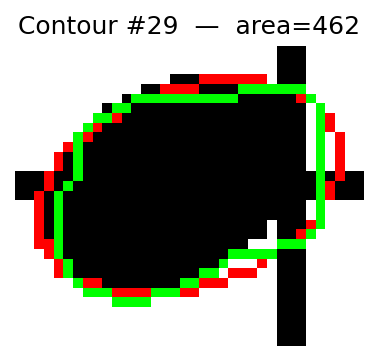

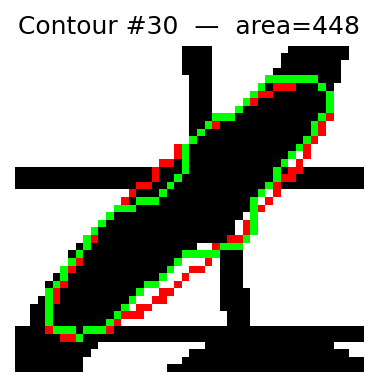

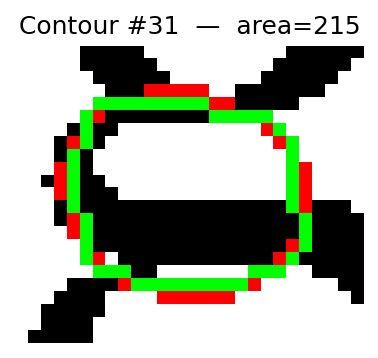

In [31]:
for i in range(1):
    test_img, notes = cropped_note_pairs[i]
    contours     = img_contours[i]

    # get gray & binary
    if not isinstance(test_img, np.ndarray):
        gray = np.array(test_img.convert('L'), dtype=np.uint8)
    else:
        gray = test_img
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

    # extract your morphed mask as normal
    morphed, _ = extract_noteheads(test_img, debug=False, ellipse_size=20)

    for idx, cnt in enumerate(contours):
        # crop & pad
        x,y,w,h = cv2.boundingRect(cnt)
        pad = 4
        x0, y0 = max(0,x-pad), max(0,y-pad)
        x1, y1 = min(gray.shape[1], x+w+pad), min(gray.shape[0], y+h+pad)
        roi_mask = morphed[y0:y1, x0:x1]
        roi_gray = gray[y0:y1, x0:x1]

        # find the single local blob in there
        local_cnts, _ = cv2.findContours(roi_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not local_cnts:
            continue
        lc = max(local_cnts, key=lambda c: cv2.contourArea(c))

        # fit ellipse
        try:
            ellipse = cv2.fitEllipse(lc)
        except:
            continue

        # draw overlay
        canvas = cv2.cvtColor(roi_gray, cv2.COLOR_GRAY2BGR)
        cv2.ellipse(canvas, ellipse, (0,0,255), 1)    # red ellipse
        cv2.drawContours(canvas, [lc], -1, (0,255,0), 1)  # green contour

        # show it
        plt.figure(figsize=(3,3), dpi=150)
        plt.imshow(canvas[..., ::-1], cmap=None)
        plt.title(f"Contour #{idx}  —  area={cv2.contourArea(lc):.0f}")
        plt.axis('off')
        plt.show()


## Notehead Extraction

# Cropping Noteheads

Given the bounding boxes drawn on the morphed images, we can take these values and overlay them on the original images to get the cropped images of the non-morphed noteheads.

# Building Dataframe

Here we will build the dataframe to be passed into our CNN model with the data being individual noteheads and the labels being the one hot encoded class names. 

# CNN Architecture

Here, we will pass in the cropped noteheads into our CNN model to do multiclass classification, determining if the notes are `noteheadBlack`, `noteheadHalf`, and `noteheadWhole`.

In [32]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping

# # find image dimensions per note head 
# # IMAGE_SHAPE = ()

# cnn_model = Sequential([
#     # First Convolutional Layer
#     Conv2D(32, (3,3), activation='relu', input_shape=IMAGE_SHAPE),
#     BatchNormalization(),
#     MaxPooling2D((2,2)),
    
#     # Second Convolutional layer
#     Conv2D(64, (3,3), activation='relu'),
#     BatchNormalization(),
#     MaxPooling2D((2,2)),
    
#     # Fully connect classifier
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.5),

#     # For single label classification (one label per image)
#     Dense(73, activation='softmax')
# ])

# cnn_model.summary()
# cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#